# 1. Problem Description
## Maintenance cost reduction through predictive techniques
### BACKGROUND

A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.
### GOAL

You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to
Predict is called failure with binary value 0 for non-failure and 1 for failure.

### Approach
By exploring the telemtry metrics over time, the machine learning algorithms can learn the relationships between different metrics' values and the device failure; the change of metrics in a time span and the history of device failure. There are a few possible applications for the maintenance prediction:
* Binary classification: Using the metrics on a certain day to predict if the probability of a device failure.(As requested in the goal)
* Regression modeling: Using the time series to predict how soon the device will fail in the future.
* Anomaly detection: Using PCA-based, SVM based or clusetering based algorithms to identical possible cause of the failure.

### Summary
- Assumption: The dataset is time series data with useful sequential information.
- Metrics for evaluation: F1 and PR-AUC
- Algorithms to test: 
 - Tree-based method: Random Forest, XGBoost 
 - Deep learning method: LSTM


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import linear_model, preprocessing, tree, model_selection
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

import category_encoders as ce


In [3]:
#Load the CSV
raw_input = pd.read_csv('predictive_maintenance.csv', parse_dates=['date'])

# 2. Exploratory Data Analysis

In [4]:
raw_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date       124494 non-null datetime64[ns]
device     124494 non-null object
failure    124494 non-null int64
metric1    124494 non-null int64
metric2    124494 non-null int64
metric3    124494 non-null int64
metric4    124494 non-null int64
metric5    124494 non-null int64
metric6    124494 non-null int64
metric7    124494 non-null int64
metric8    124494 non-null int64
metric9    124494 non-null int64
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [4]:
raw_input.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [5]:
raw_input.head(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


b:\program files\phthon\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
b:\program files\phthon\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
b:\program files\phthon\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
b:\program files\phthon\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6F8F49C50>,
      dtype=object)

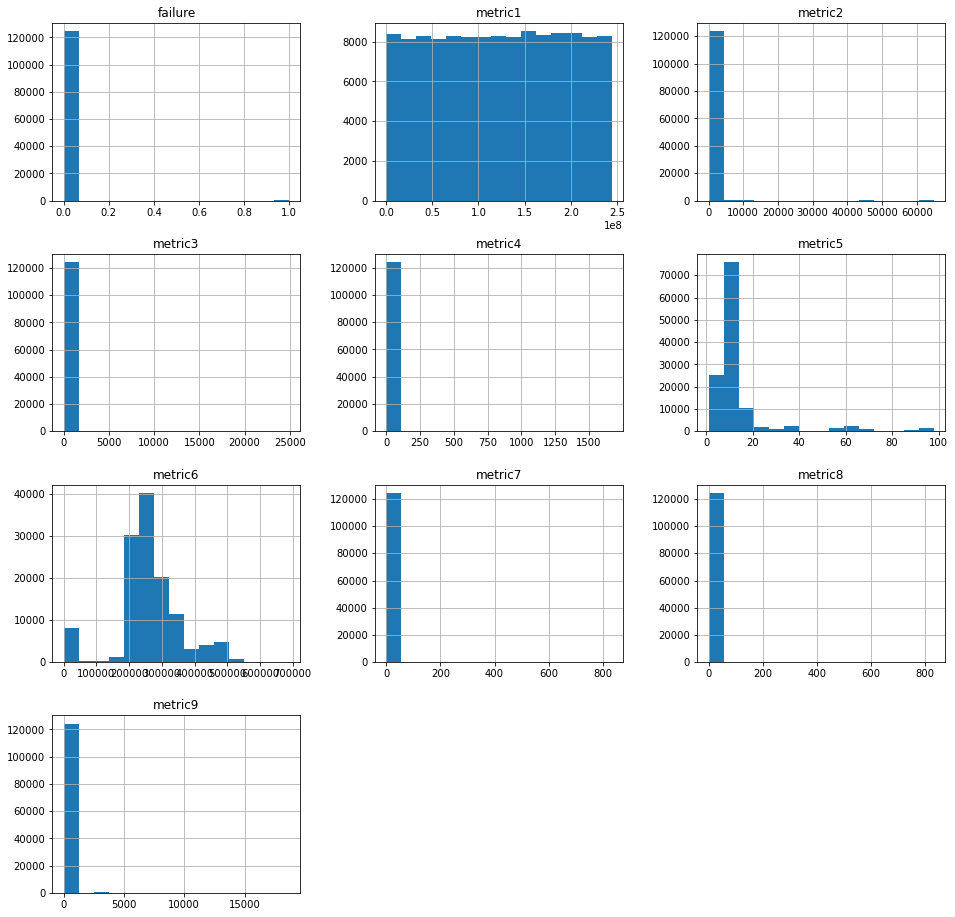

In [6]:
#plot the histogram for each metric to double check the distribution.
raw_input.hist(bins=15, figsize=(16,16), layout=(4,3))

### observations:
* There is no missing data in all columns
* The metric1 and metric6 are a few magnitude larger than other metrics.
* The metric7 and metric8 appear to be the same
* The failure rate is only 0.085% in this data set
* The distribution of metric2, 3, 4, 7, 8, 9 are highly skewed towards right


Let's take a look of what failure = 1 data look like comparing to the failure = 0

In [7]:
raw_input.sample(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
25569,2015-02-01,W1F1CL8Q,0,137661104,0,0,0,11,246710,0,0,0
27581,2015-02-04,W1F0VC83,0,76687632,0,0,0,9,309797,0,0,2
103062,2015-07-15,S1F0S561,0,162961584,0,0,0,14,271212,0,0,0
2737,2015-01-03,S1F10QDG,0,209486056,0,0,0,5,212185,0,0,0
80648,2015-05-12,S1F0QWGA,0,222754232,0,0,0,7,217049,0,0,0


In [8]:
raw_input.loc[raw_input.failure == 1].sample(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
96744,2015-06-26,Z1F0LSNZ,1,149049520,0,318,0,6,323187,0,0,19
79601,2015-05-09,W1F0M35B,1,141805096,0,0,1,7,267203,0,0,0
79379,2015-05-08,Z1F1AG5N,1,13095344,32,0,10,7,24,0,0,0
104019,2015-07-18,S1F09DZQ,1,77351504,2304,0,3,7,418563,0,0,2
78860,2015-05-07,W1F1C9WG,1,161019312,0,0,0,13,49,0,0,0


There is no eye-catching pattern from these 10 sample comparison. （but notice that the entry 6879 has non-zero readings at metric2,4,7,8; entry 78860 has abnormally small reading at metric6）

In [9]:
raw_input[['date', 'device']].describe()

,date,device
count,124494,124494
unique,304,1169
top,2015-01-03 00:00:00,Z1F0KKN4
freq,1163,304
first,2015-01-01 00:00:00,NaN
last,2015-11-02 00:00:00,NaN


In [10]:
raw_input[raw_input.duplicated(keep=False) == True]

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
101334,2015-07-10,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0
101335,2015-07-10,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0


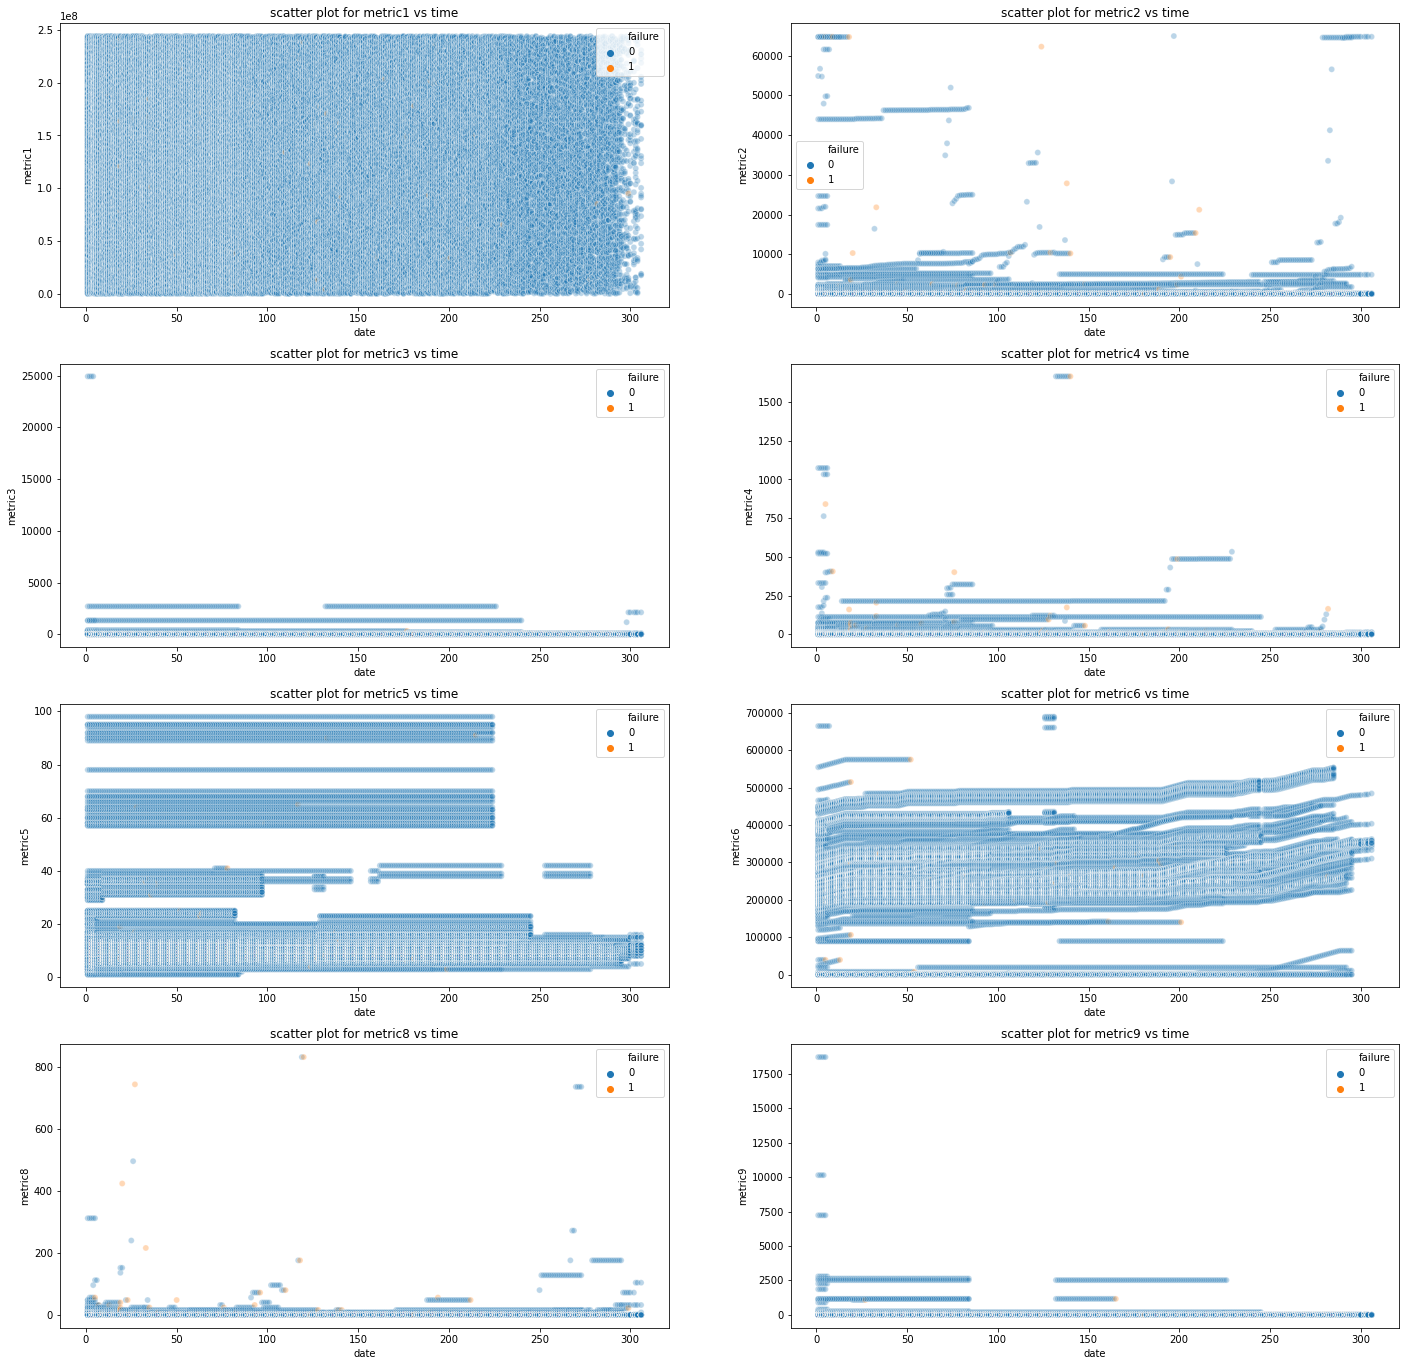

In [11]:
tempraw = raw_input.copy()
tempraw['date'] = tempraw['date'].dt.dayofyear

allmetrics = ['metric1','metric2','metric3','metric4','metric5','metric6','metric8','metric9']
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,2,n)
    sns.scatterplot(x='date', y=each, hue='failure', data=tempraw, alpha=0.3)
    plt.title('scatter plot for {} vs time'.format(each))
    n += 1



### observations:
* There are 304 unique date(not a full year), and 1169 unique devices in this data set
* The most frequent date: 1/1/15, most frequent device: W1F0JY02
* There is 1 duplicated row.
* Since these are highly skewed metrics, we cannot rely on the box plot to QC the outliers. The scatter plot doesn't show obvious patterns concerning failure nor the abnomaly.

Let's track a failed device's metrics reading across different dates

In [12]:
raw_input.loc[raw_input.failure == 1].tail(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
109927,2015-08-04,W1F1CB5E,1,16043296,88,0,0,9,30,0,0,0
114251,2015-08-18,Z1F0MRPJ,1,65654088,0,0,0,9,298592,0,0,11
122118,2015-10-05,S1F0JGJV,1,13739704,0,0,18,8,343760,0,0,0
122808,2015-10-09,Z1F14BGY,1,85259320,0,0,164,8,262932,0,0,0
124329,2015-10-26,W1F0T0B1,1,95073232,0,0,7,9,354861,22,22,0


In [13]:
raw_input[raw_input['device'] == 'W1F0T0B1'].tail(10)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
123737,2015-10-17,W1F0T0B1,0,134001600,0,0,0,9,346956,16,16,0
123846,2015-10-18,W1F0T0B1,0,167807360,0,0,0,9,348227,16,16,0
123955,2015-10-19,W1F0T0B1,0,191684320,0,0,0,9,349464,16,16,0
124040,2015-10-20,W1F0T0B1,0,216226120,0,0,0,9,350697,16,16,0
124109,2015-10-21,W1F0T0B1,0,240025832,0,0,0,9,351917,16,16,0
124178,2015-10-22,W1F0T0B1,0,112824920,0,0,0,9,352949,16,16,0
124233,2015-10-23,W1F0T0B1,0,52620456,0,0,0,9,352949,16,16,0
124265,2015-10-24,W1F0T0B1,0,154144032,0,0,0,9,352949,16,16,0
124297,2015-10-25,W1F0T0B1,0,86280056,0,0,7,9,354072,22,22,0
124329,2015-10-26,W1F0T0B1,1,95073232,0,0,7,9,354861,22,22,0


In [14]:
raw_input[raw_input['device'] == 'S1F0CTDN'].tail(10)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,32,3
1226,2015-01-02,S1F0CTDN,0,72104024,528,0,4,9,382459,32,32,3
2389,2015-01-03,S1F0CTDN,0,91492168,528,0,4,9,383713,32,32,3
3552,2015-01-04,S1F0CTDN,0,112311608,528,0,4,9,384948,32,32,3
4713,2015-01-05,S1F0CTDN,0,134261688,528,0,4,9,386214,32,32,3
5856,2015-01-06,S1F0CTDN,0,159974064,528,0,4,9,387343,32,32,3
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,32,3


### Observations:
* The metric6 reading seems to increase with time.
* Different devices have different metric pattern: S1F0CTDN has constant metric4, 9 reading, while W1F0T0B1 hasn't.


In [15]:
raw_input[raw_input['device'] == 'W1F0JY02'].tail(10)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
124175,2015-10-22,W1F0JY02,0,33860224,0,0,0,7,346835,0,0,0
124230,2015-10-23,W1F0JY02,0,97384744,0,0,0,7,346838,0,0,0
124262,2015-10-24,W1F0JY02,0,108256928,0,0,0,7,346840,0,0,0
124294,2015-10-25,W1F0JY02,0,54892240,0,0,0,7,348006,0,0,0
124326,2015-10-26,W1F0JY02,0,237282984,0,0,0,7,348817,0,0,0
124358,2015-10-27,W1F0JY02,0,125900704,0,0,0,8,349093,0,0,0
124389,2015-10-29,W1F0JY02,0,123667440,0,0,0,8,350033,0,0,0
124420,2015-10-30,W1F0JY02,0,140311808,0,0,0,8,350754,0,0,0
124451,2015-10-31,W1F0JY02,0,1401232,0,0,0,8,350759,0,0,0
124482,2015-11-02,W1F0JY02,0,226850672,0,0,0,8,351379,0,0,0


In [18]:
raw_input.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

### Observations:
* There are 106 out of 1169 devices failed during the date recorded.
* The telemetric readings are not strictly on daily basis.

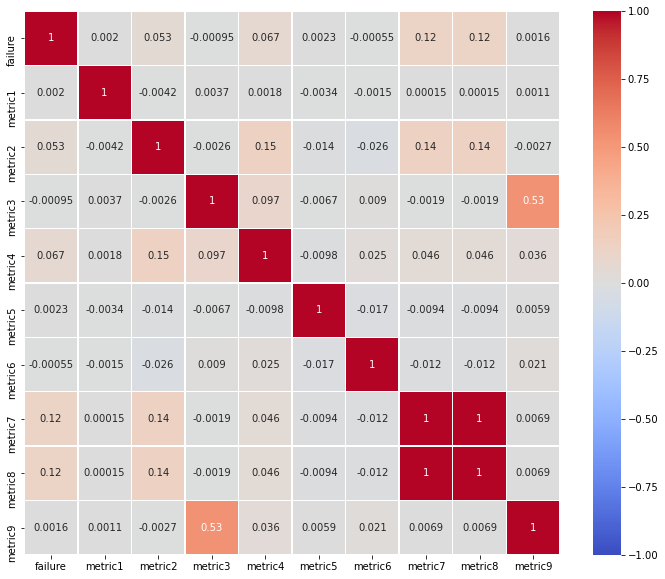

In [19]:
#What's the correlation between these metrics?
corr = raw_input.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', linewidth=.5, annot=True, vmin=-1, vmax=1)

In [20]:
#check if the metric7 and metric8 are exactly the same
(raw_input['metric8'] - raw_input['metric7']).unique()

array([0], dtype=int64)

### Observations:
* The metric7 and metric8 are the same, we can drop one of them
* The metric3 and metric9 are highly correlated

In [21]:
#find the failed devices with long telemetry recording
failureqc = raw_input.groupby('device').failure.agg([len,sum])
failureqc.sort_values(by=['sum','len']).tail()

,len,sum
device,,
W1F11ZG9,229,1
Z1F0MRPJ,230,1
S1F0JGJV,278,1
Z1F14BGY,282,1
W1F0T0B1,299,1


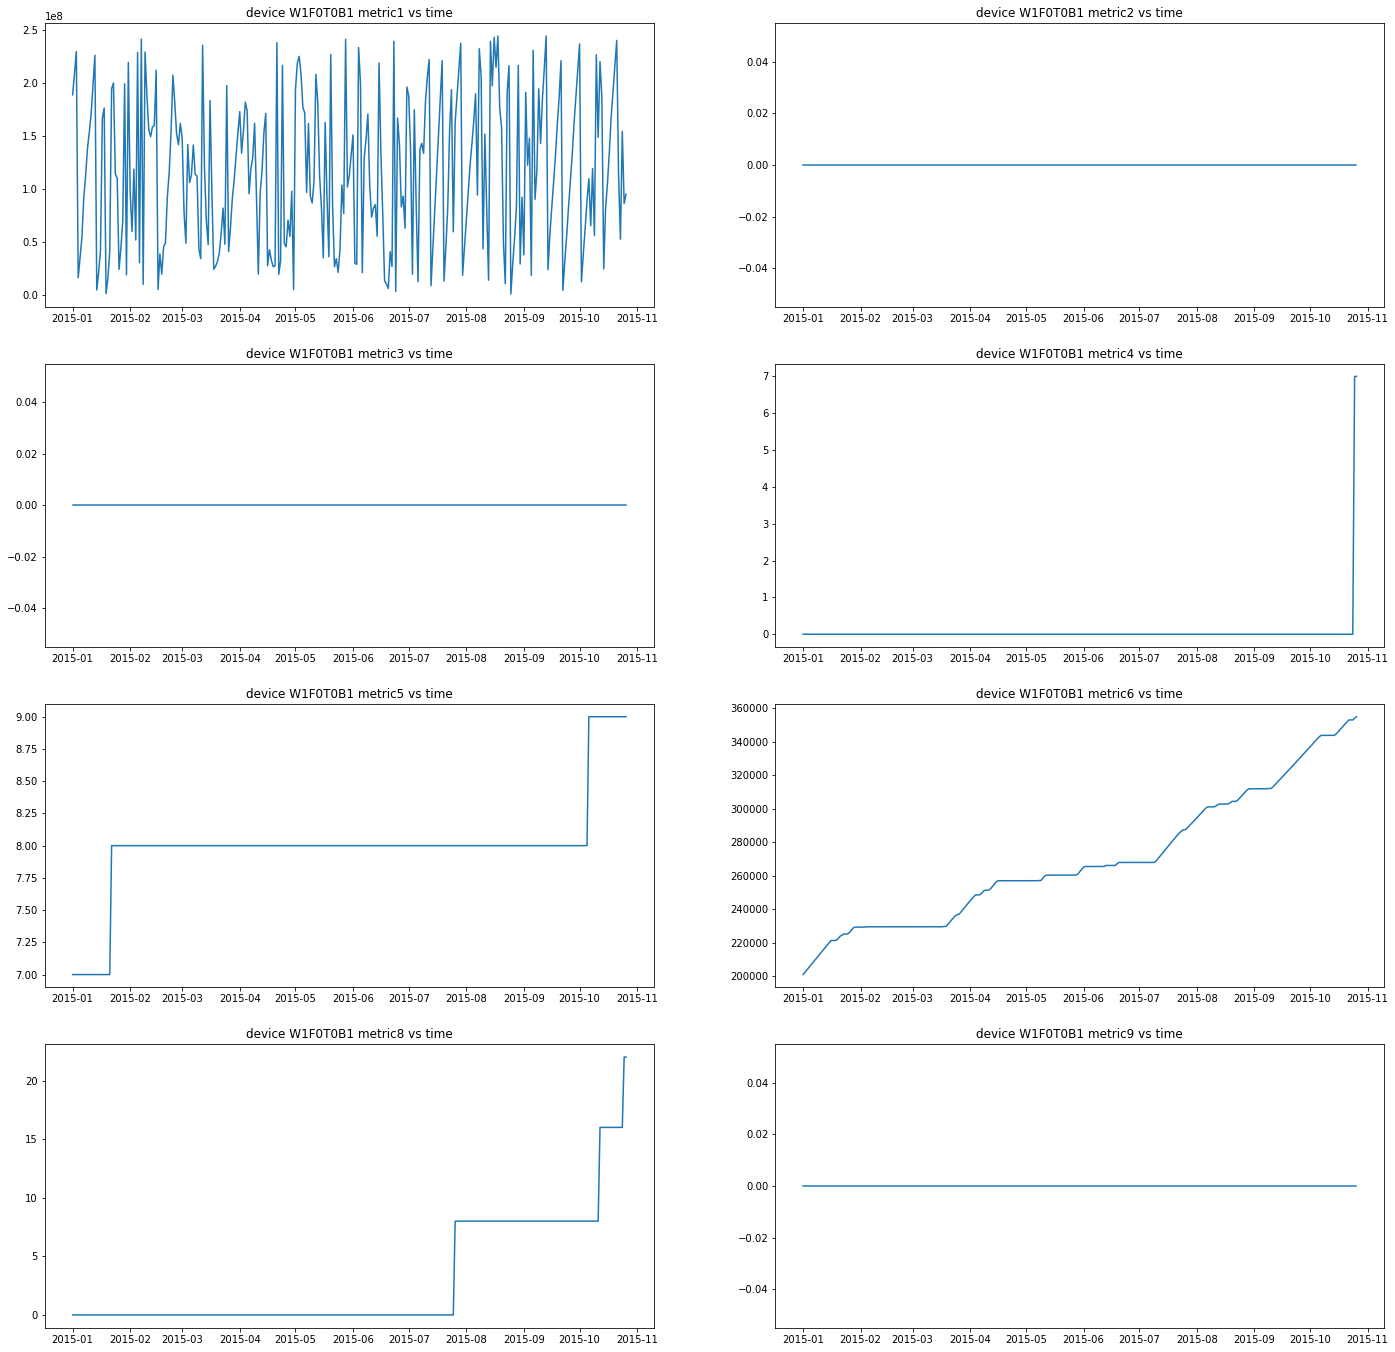

In [22]:
#case1: failed case W1F0T0B1 with longest record
case1 = raw_input[raw_input['device'] == 'W1F0T0B1']
allmetrics = ['metric1','metric2','metric3','metric4','metric5','metric6','metric8','metric9']
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,2,n)
    plt.plot('date',each,data=case1)
    plt.title('device W1F0T0B1 {} vs time'.format(each))
    n += 1

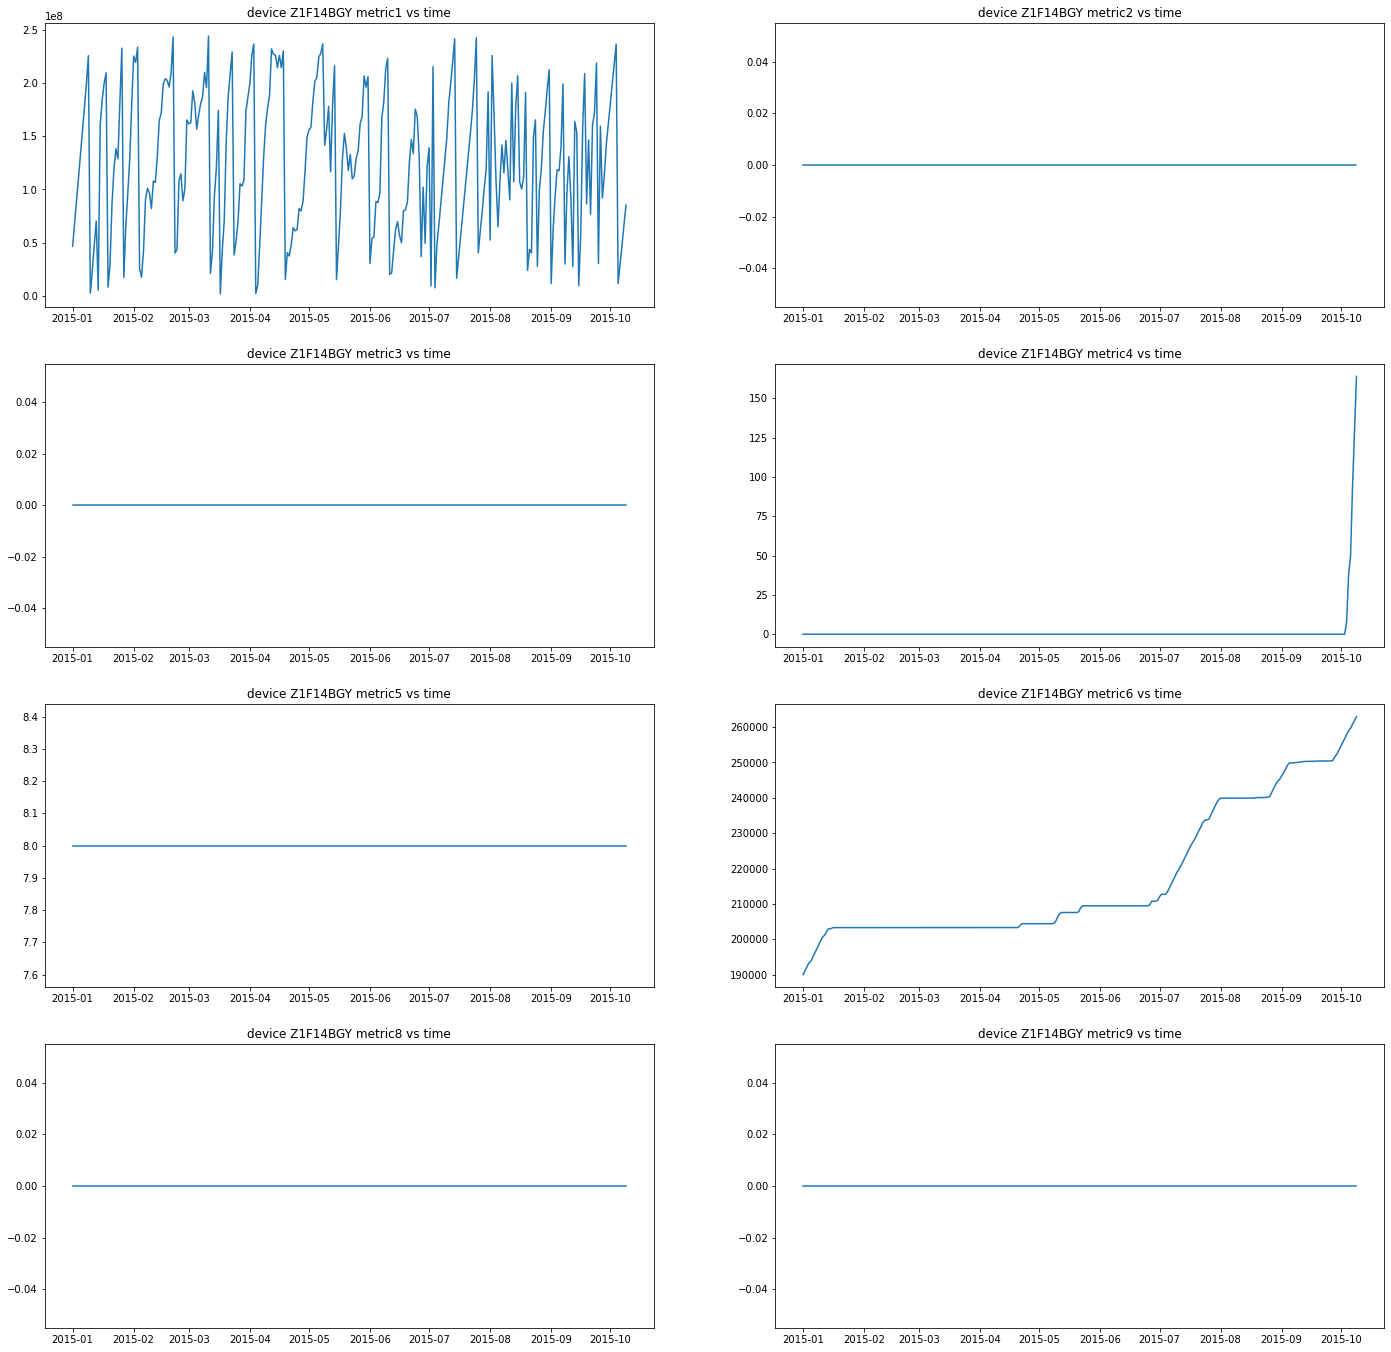

In [23]:
#case2: failed case Z1F14BGY
case2 = raw_input[raw_input['device'] == 'Z1F14BGY']
allmetrics = ['metric1','metric2','metric3','metric4','metric5','metric6','metric8','metric9']
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,2,n)
    plt.plot('date',each,data=case2)
    plt.title('device Z1F14BGY {} vs time'.format(each))
    n += 1

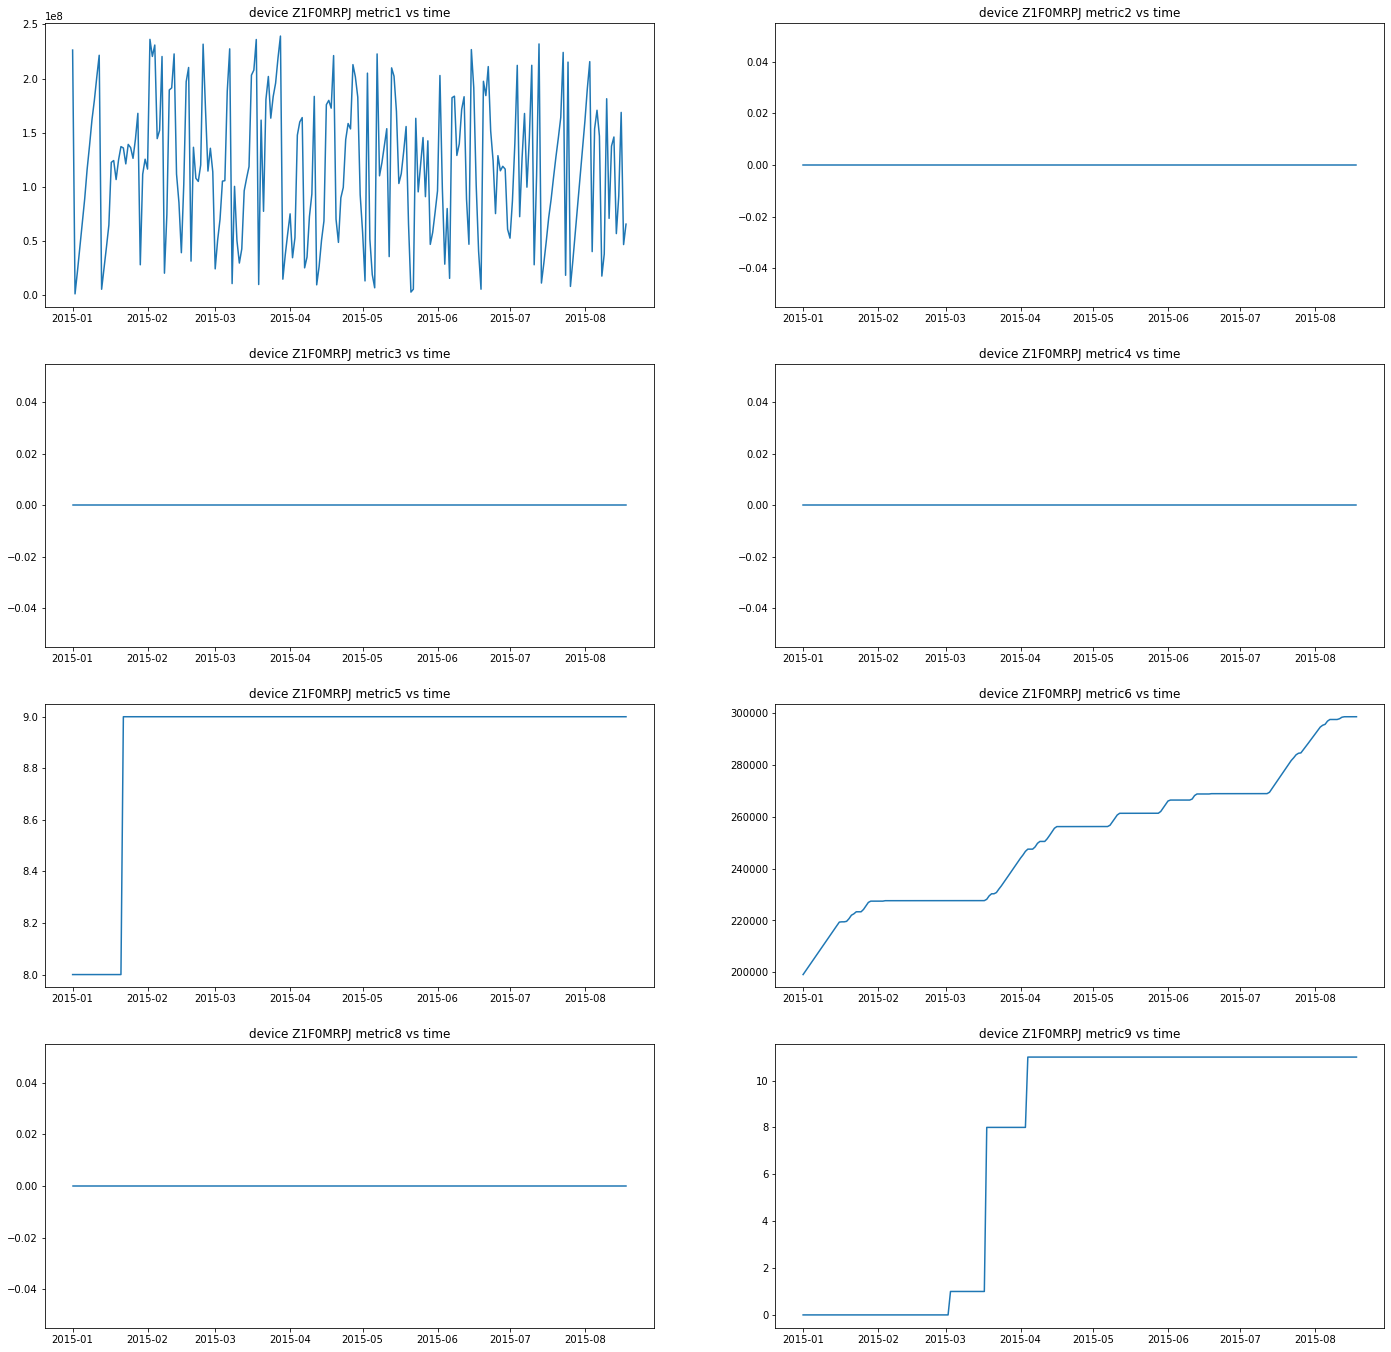

In [24]:
#case3: failed case Z1F0MRPJ
case3 = raw_input[raw_input['device'] == 'Z1F0MRPJ']
allmetrics = ['metric1','metric2','metric3','metric4','metric5','metric6','metric8','metric9']
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,2,n)
    plt.plot('date',each,data=case3)
    plt.title('device Z1F0MRPJ {} vs time'.format(each))
    n += 1

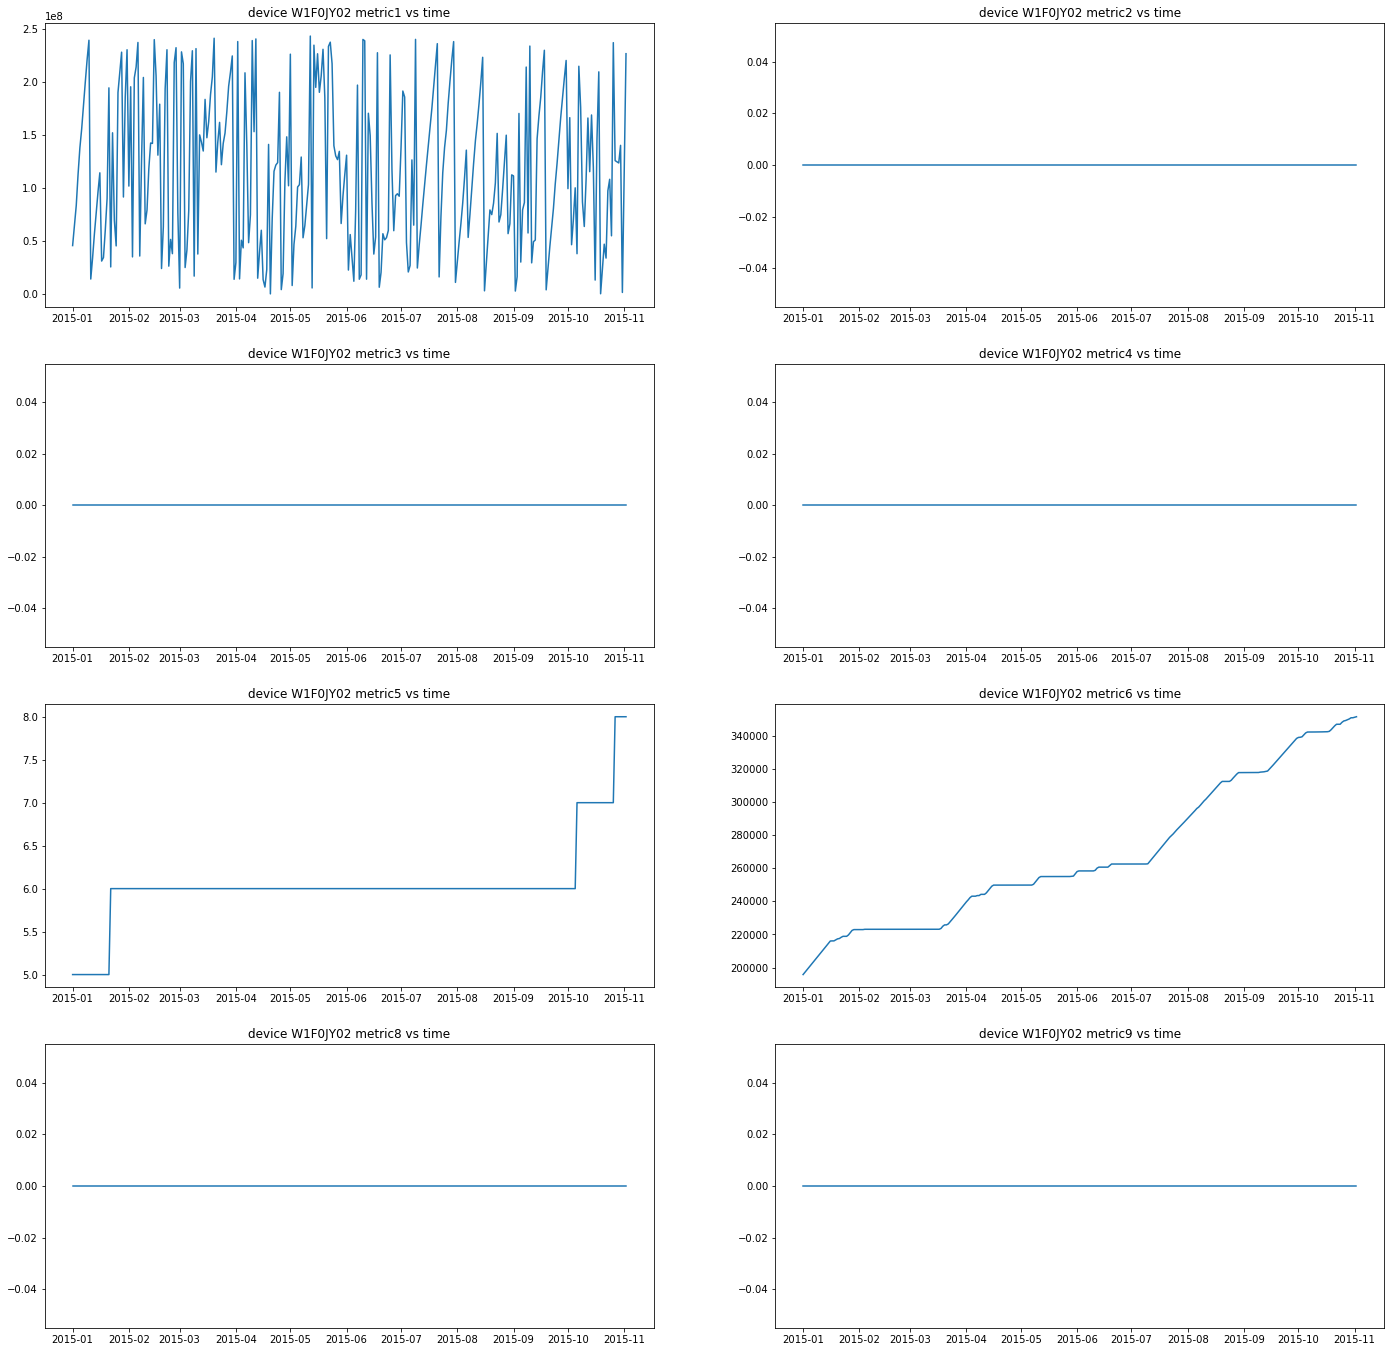

In [25]:
#case4: the most frequent case W1F0JY02(not failed)
case4 = raw_input[raw_input['device'] == 'W1F0JY02']
allmetrics = ['metric1','metric2','metric3','metric4','metric5','metric6','metric8','metric9']
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,2,n)
    plt.plot('date',each,data=case4)
    plt.title('device W1F0JY02 {} vs time'.format(each))
    n += 1

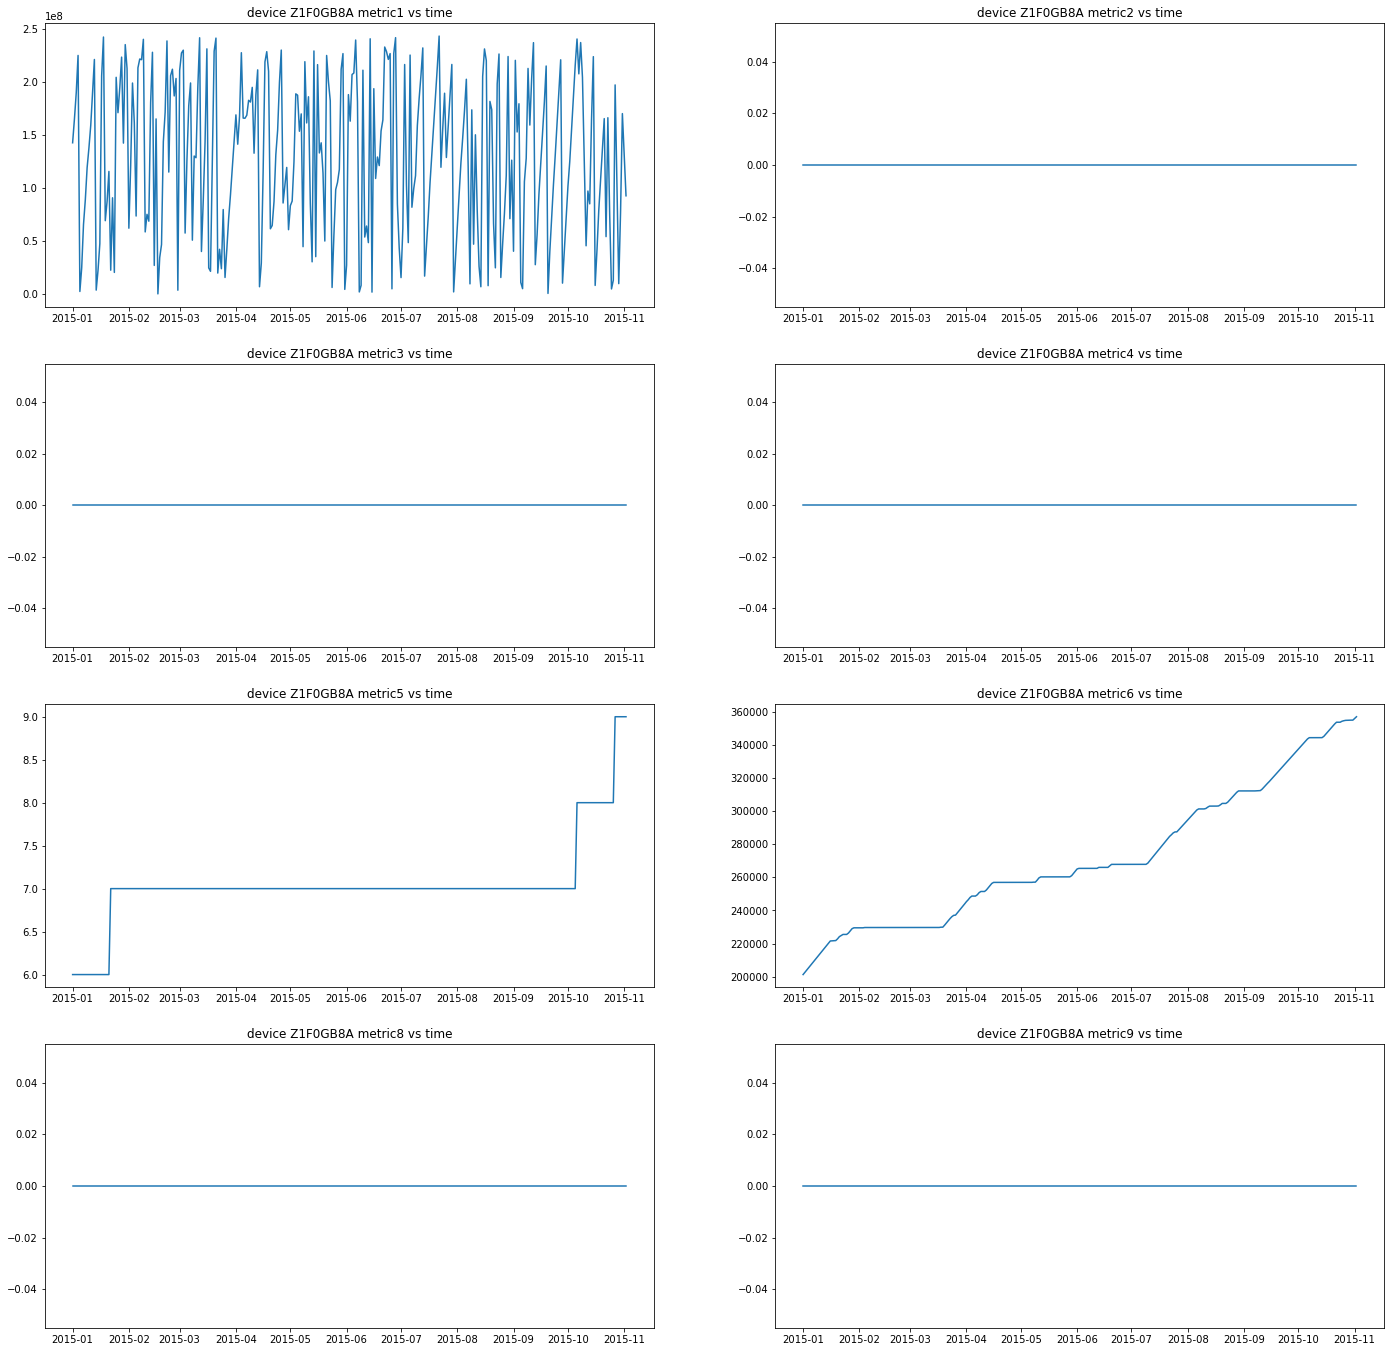

In [26]:
#case5: case Z1F0GB8A(not failed)
case5 = raw_input[raw_input['device'] == 'Z1F0GB8A']
allmetrics = ['metric1','metric2','metric3','metric4','metric5','metric6','metric8','metric9']
plt.figure(figsize=(24,24))
n = 1
for each in allmetrics:
    plt.subplot(4,2,n)
    plt.plot('date',each,data=case5)
    plt.title('device Z1F0GB8A {} vs time'.format(each))
    n += 1

### Observations:
* The metric4 spikes seem to be related to the failure. Let's plot all metrics for different devices in failed/not_failed conditions. More plots comparison at:[metrics_failed](https://public.tableau.com/profile/vincent5202#!/vizhome/all_metrics_failed/metrics_failed?publish=yes), 
[metrics_not_failed](https://public.tableau.com/profile/vincent5202#!/vizhome/all_metrics_not_failed/metrics_not_failed?publish=yes)
* The metrics2, 4, 7 all have a lot of spikes in both failed and not_failed cases, but slightly more in the failed cases.

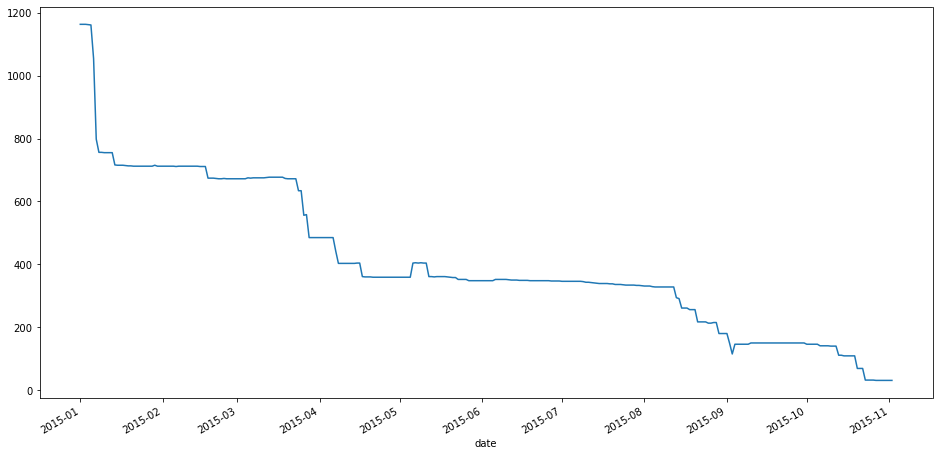

In [27]:
#What's the trend of number of devices vs time look like
plt.figure(figsize=(16,8))
raw_input.groupby(['date']).device.count().plot()

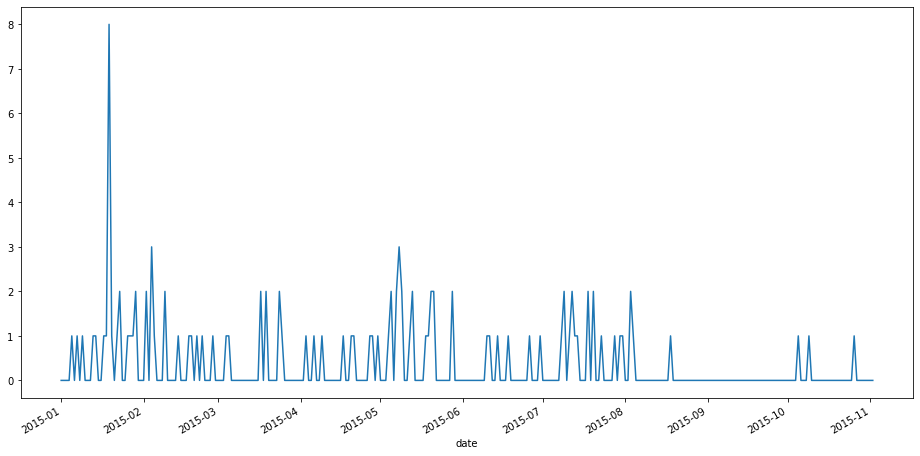

In [28]:
#what's the failure count of devices vs time look like
plt.figure(figsize=(16,8))
raw_input.groupby(['date']).failure.sum().plot()

In [29]:
#check if there are any redeployed devices after reported failure
faillist = raw_input[raw_input.failure == 1].values

for each in faillist:
    
    date = each[0]
    device = each[1]
    if raw_input.loc[(raw_input.device == device) & (raw_input.date > date)].empty is False:
        print('there are fixed devices deployed:', raw_input.loc[(raw_input.device == device) & (raw_input.date > date)])

there are fixed devices deployed:             date    device  failure    metric1  metric2  metric3  metric4  \
78335 2015-05-06  S1F136J0        0  194511456        0        0       28   

       metric5  metric6  metric7  metric8  metric9  
78335       16   343593        0        0        0  
there are fixed devices deployed:             date    device  failure    metric1  metric2  metric3  metric4  \
79995 2015-05-10  W1F0KCP2        0  123051360    10392        0      121   
80399 2015-05-11  W1F0KCP2        0  140419256    10440        0      121   

       metric5  metric6  metric7  metric8  metric9  
79995        6   310735        0        0        0  
80399        6   310801        0        0        0  
there are fixed devices deployed:             date    device  failure    metric1  metric2  metric3  metric4  \
80006 2015-05-10  W1F0M35B        0  158339032       96        0        1   
80410 2015-05-11  W1F0M35B        0  181444320      456        0        1   

       metric5

### Observations:
* There is a steep drop of device counts at early of 2015-01, where there isn't a spike at failure plot. That's because there are devices stop recording for other reasons.
* Notice the device count plot is not a monotonic function with date, there are new devices added near 2015-05 where there is a failure spike around. 
* There are 5 failed devices found redeployed: S1F136J0, W1F0KCP2, W1F0M35B, S1F0GPFZ, W1F11ZG9. They are redeployed right after the failed date.

## EDA Summary:
* There is no missing data in all columns, all metrics are integer data type; there is 1 duplicated row.
* The metric1 and metric6 are a few magnitude larger than other metrics. The metric6 reading seems to be monotonically increasing with time.
* The metric7 and metric8 are the same; the metric3 and metric9 are highly correlated.
* The distribution of metric2, 3, 4, 7, 8, 9 are highly skewed towards right
* There are 304 unique date(not a full year), and 1169 unique devices in this data set. The most frequent date: 1/1/15, most frequent device: W1F0JY02
* It's a imbalanced dataset with failure rate of only 0.085%. There are 106 out of 1169 devices failed during the date recorded. Failed devices stop recording into this dataset; There are also devices stop recording without failure recorded.
* Different devices have different metric pattern, some devices only have valid reading on certain telemetries.
* The telemetric readings are not strictly on daily basis.
* The sudden surge of some metrics might indicate failure, or imminent failure. e.g. metric4
* There is a steep drop of device counts at early of 2015-01, where there isn't a spike at failure plot. That's because there are devices stop recording for other reasons.
* There are 5 failed devices found redeployed: S1F136J0, W1F0KCP2, W1F0M35B, S1F0GPFZ, W1F11ZG9. They are redeployed right after the failed date.

# 3. Baseline Model and Data Preprocessing

## 3.1. Baseline model on raw input
* Without any data wrangling, feature engineering and hyperparameter tuning, let's get our feet wet by creating a baseline model feeding all the raw featues with minimum data preprocessing.
* For classification problem of a highly imbalanced dataset, we will use precision, recall, PR-AUC and F1 score as evaluation metrics. ROC-AUC is also showed for comparison, not as a metric.
* Precision_Recall_curve will be used to evalute the overall model performance. Precision is more focused in the positive class than in the negative class, it actually measures the probability of correct detection of positive values, while FPR and TPR measure the ability to distinguish between the classes.
* The model chosen for baseline is the versatile and robust Random Forest


In [30]:
#get preparation for the baseline model tests, first step is to remove the duplicates
base_input = raw_input.copy()
base_input.drop_duplicates()
base_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date       124494 non-null datetime64[ns]
device     124494 non-null object
failure    124494 non-null int64
metric1    124494 non-null int64
metric2    124494 non-null int64
metric3    124494 non-null int64
metric4    124494 non-null int64
metric5    124494 non-null int64
metric6    124494 non-null int64
metric7    124494 non-null int64
metric8    124494 non-null int64
metric9    124494 non-null int64
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [31]:
#let's prepare the input datasets by converting all object and datetime features to numerical, using the simplest label-encoder.
le = LabelEncoder()
base_input['device'] = le.fit_transform(base_input['device'])
base_input['date'] = base_input['date'].dt.dayofyear
base_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date       124494 non-null int64
device     124494 non-null int32
failure    124494 non-null int64
metric1    124494 non-null int64
metric2    124494 non-null int64
metric3    124494 non-null int64
metric4    124494 non-null int64
metric5    124494 non-null int64
metric6    124494 non-null int64
metric7    124494 non-null int64
metric8    124494 non-null int64
metric9    124494 non-null int64
dtypes: int32(1), int64(11)
memory usage: 10.9 MB


In [32]:
base_input.sample(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
51322,70,118,0,174924816,0,0,0,7,309451,0,0,0
28666,37,154,0,97591784,0,0,0,12,272694,0,0,0
40678,54,392,0,146504928,0,0,0,10,219618,0,0,6
112979,226,234,0,186490816,0,0,0,8,299069,0,0,0
67129,96,894,0,192780840,0,0,0,13,255203,0,0,0


In [33]:
#split the data with imbalanced classes with stratified sampling
base_X = base_input[['date', 'device', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric8', 'metric9']]
base_y = base_input[['failure']]
X_train, X_test, y_train, y_test = train_test_split(base_X, base_y, train_size=0.8, random_state=42, stratify=base_y)


In [34]:
#since this is a highly imbalanced date, let's get to see the accuracy score by predicting 0 for all training dataset
X_trainv = X_train.values
y_trainv = y_train.values
X_testv = X_test.values
y_testv = y_test.values

#define F1 score class
target = 1 # class you want to plot
scorer = make_scorer(lambda y_true, y_pred: f1_score(
    y_true, y_pred, 
    labels=None, 
    pos_label=target,  
    sample_weight=None))

dummy_clf = len(y_testv)*[0]
print('The best score for blind guess is:', (1 - sum(y_testv)/len(y_testv)))
print('The confusion matrix for blind guess is:\n', confusion_matrix(y_true=y_testv, y_pred=dummy_clf, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=dummy_clf, labels=[1, 0], digits=4))

The best score for blind guess is: [0.99915659]
The confusion matrix for blind guess is:
 [[    0    21]
 [    0 24878]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        21
          0     0.9992    1.0000    0.0000    0.9996    0.0000    0.0000     24878

avg / total     0.9983    0.9992    0.0008    0.9987    0.0000    0.0000     24899



b:\program files\phthon\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* pre is precision, it's a metric that quantifies the number of correct positive predictions made.
* rec is recall, also known as sensitivity. Recall measures the proportion of positives that are correctly identified.
* spe is specificity, it measures the proportion of negatives that are correctly identified
* f1 is the harmonic average of the precision and recall;
* geo is the geometric mean of specificity and sensitivity;
* iba is the index of imbalanced accuracy
* sup is support, it's the number of actual occurrences of the class in the specified dataset.

In [153]:
#feed the data to Random Forest with default hyperparameters 
rf = RandomForestClassifier(random_state=42)
rf_clf = rf.fit(X_trainv, y_trainv)
cv_score = cross_val_score(rf, X_trainv, y_trainv, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-

the mean score of 5 cv sets for the baseline model is: 0.0


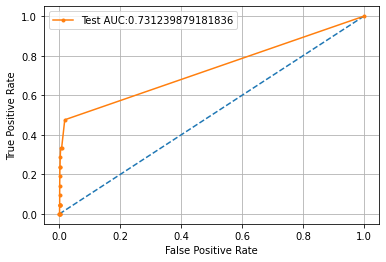

AUC for the model is: 0.731239879181836


In [154]:
y_scores = rf.predict_proba(X_testv)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_testv, y_scores)
rocauc = roc_auc_score(y_testv, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

The confusion matrix for Random Forest is:
 [[    0    21]
 [    3 24875]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.0000    0.0000    0.9999    0.0000    0.0000    0.0000        21
          0     0.9992    0.9999    0.0000    0.9995    0.0000    0.0000     24878

avg / total     0.9983    0.9990    0.0008    0.9987    0.0000    0.0000     24899



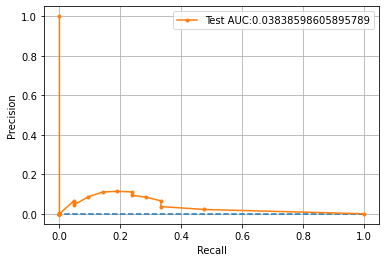

AUC for the model is: 0.03838598605895789


In [155]:
y_predv = rf_clf.predict(X_testv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predv, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predv, labels=[1, 0], digits=4))


y_scores = rf.predict_proba(X_testv)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testv, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

### Observations:
* Directly feed the raw data to the Random Forest model gives F1 = 0, meaning no TP. The PR-AUC shows possibility of correct prediction by adjusting the threshold.
* It's needed to test the resampling of the imbalanced dataset before testing out the baseline model.
* The following resampling tests are compared:
    1. Upsampling the minority
    2. Downsampling the majority
    3. SMOTE synthetic upsampling
    4. Combo of SMOTE and majority downsampling

## 3.2 Baseline model with further data preprocessing

In [37]:

trainset = pd.concat([X_train, y_train], axis=1)
failed = trainset[trainset.failure == 1]
notfailed = trainset[trainset.failure == 0]


#upsample the minority
failed_upsampled = resample(failed, replace=True, n_samples=len(notfailed), random_state=42)

upsampled = pd.concat([notfailed, failed_upsampled])

upsampled.failure.value_counts()

1    99510
0    99510
Name: failure, dtype: int64

In [38]:
upsampled[upsampled.failure == 1].sort_values(by='device').head()

,date,device,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,failure
15773,19,8,64499464,0,0,1,19,514661,16,3,1
15773,19,8,64499464,0,0,1,19,514661,16,3,1
15773,19,8,64499464,0,0,1,19,514661,16,3,1
15773,19,8,64499464,0,0,1,19,514661,16,3,1
15773,19,8,64499464,0,0,1,19,514661,16,3,1


In [39]:
y_trainus = upsampled['failure']
X_trainus = upsampled.drop(['failure'],1)
X_trainus.sample(5)

,date,device,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9
26157,33,700,201059304,960,0,118,36,277338,216,2
19521,24,374,134185720,0,0,0,8,193450,0,6
43935,59,207,91093248,0,0,0,12,243739,0,0
37295,49,371,194314640,0,0,0,8,313659,0,1
58583,80,980,1327744,0,2,0,94,241350,0,0


In [150]:

X_trainusv = X_trainus.values
y_trainusv = y_trainus.values 
rf1 = RandomForestClassifier(random_state=42)
rf1_clf = rf1.fit(X_trainusv, y_trainusv)
cv_score = cross_val_score(rf1, X_trainusv, y_trainusv, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

the mean score of 5 cv sets for the baseline model is: 0.9998894737440217


In [151]:
y_trpredusv = rf1.predict(X_trainusv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_trainusv, y_pred=y_trpredusv, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_trainusv, y_pred=y_trpredusv, labels=[1, 0], digits=4))

The confusion matrix for Random Forest is:
 [[99510     0]
 [    0 99510]]
                   pre       rec       spe        f1       geo       iba       sup

          1     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000     99510
          0     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000     99510

avg / total     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000    199020



In [152]:
y_predusv = rf1.predict(X_testv)

cv_score = cross_val_score(rf1, X_testv, y_testv, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predusv, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predusv, labels=[1, 0], digits=4))

b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was pa

the mean score of 5 cv sets for the baseline model is: 0.0
The confusion matrix for Random Forest is:
 [[    0    21]
 [    4 24874]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.0000    0.0000    0.9998    0.0000    0.0000    0.0000        21
          0     0.9992    0.9998    0.0000    0.9995    0.0000    0.0000     24878

avg / total     0.9983    0.9990    0.0008    0.9987    0.0000    0.0000     24899



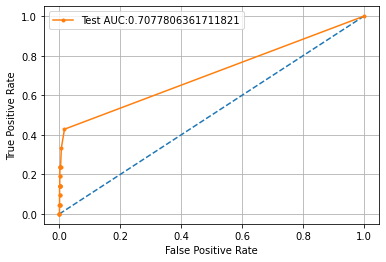

AUC for the model is: 0.7077806361711821


In [130]:
y_scores = rf1.predict_proba(X_testv)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_testv, y_scores)
rocauc = roc_auc_score(y_testv, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

### Observations:
* The upsampling method gives F1=0, with 0 TP as well.
* Let's try the downsampling method next.

In [43]:
#dowsample the majority


rus = RandomUnderSampler(random_state=42)
X_trainds, y_trainds = rus.fit_sample(X_train, y_train)

print(y_trainds.failure.value_counts())
X_trainds.sample(5)

1    85
0    85
Name: failure, dtype: int64


,date,device,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9
135,27,534,166313728,0,8,19,17,331619,744,1080
30,74,996,33664704,0,0,0,6,316956,0,0
56,224,337,12213056,0,1,0,7,299846,0,7
27,2,228,75276784,0,0,27,11,216368,0,0
31,208,584,52466552,0,0,0,17,230926,0,0


In [44]:
#feed the data to Random Forest with default hyperparameters 
X_traindsv = X_trainds.values
y_traindsv = y_trainds.values 

rf2 = RandomForestClassifier(random_state=42)
rf2_clf = rf2.fit(X_traindsv, y_traindsv)
cv_score = cross_val_score(rf2, X_traindsv, y_traindsv, scoring=scorer, cv=5).mean()
#predicted = cross_val_predict(rf2, X_traindsv, y_traindsv, cv=skftrainds)
#print(f1_score(y_traindsv, predicted))
print('the mean score of 5 cv sets for the baseline model is:',cv_score)


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

the mean score of 5 cv sets for the baseline model is: 0.8127077223851418


In [45]:
rf2 = RandomForestClassifier(random_state=42)
rf2_clf = rf2.fit(X_traindsv, y_traindsv)
cv_score = cross_val_score(rf2, X_traindsv, y_traindsv, scoring=scorer, cv=5).mean()
#predicted = cross_val_predict(rf2, X_traindsv, y_traindsv, cv=skftrainds)
#print(f1_score(y_traindsv, predicted))
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

the mean score of 5 cv sets for the baseline model is: 0.8127077223851418


In [46]:
y_trpreddsv = rf2.predict(X_traindsv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_traindsv, y_pred=y_trpreddsv, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_traindsv, y_pred=y_trpreddsv, labels=[1, 0], digits=4))

The confusion matrix for Random Forest is:
 [[85  0]
 [ 0 85]]
                   pre       rec       spe        f1       geo       iba       sup

          1     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000        85
          0     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000        85

avg / total     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000       170



In [47]:
y_preddsv = rf2.predict(X_testv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_preddsv, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_preddsv, labels=[1, 0], digits=4))

The confusion matrix for Random Forest is:
 [[   16     5]
 [ 3441 21437]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.0046    0.7619    0.8617    0.0092    0.8103    0.6500        21
          0     0.9998    0.8617    0.7619    0.9256    0.8103    0.6631     24878

avg / total     0.9989    0.8616    0.7620    0.9248    0.8103    0.6631     24899



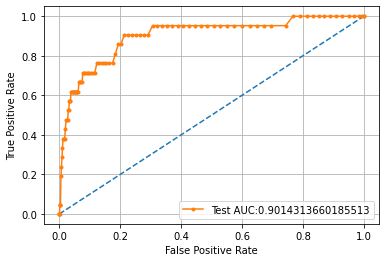

AUC for the model is: 0.9014313660185513


In [126]:
y_scores = rf2.predict_proba(X_testv)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_testv, y_scores)
rocauc = roc_auc_score(y_testv, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

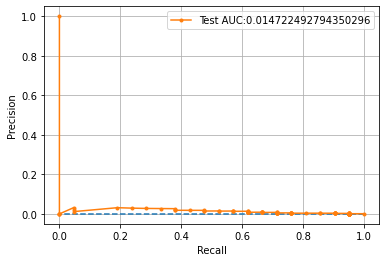

AUC for the model is: 0.014722492794350296


In [125]:
y_scores = rf2.predict_proba(X_testv)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testv, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

### Observations:
* The problem with downsampling is that there are only 170 data entries to feed into the model after sampling. With more than 10 features, the model is likely to overfit.
* The downsampling test gives F1=0.0092, with 16 TP.
* Let's keep try the SMOTE to upsample next.

In [48]:
# using SMOTE to upsample the minority



smt = SMOTE(random_state = 42)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

X_trainsmtv = X_train_smt.values
y_trainsmtv = y_train_smt.values

rf2smt = RandomForestClassifier(random_state=42)
rf2smt_clf = rf2smt.fit(X_trainsmtv, y_trainsmtv)
cv_score = cross_val_score(rf2smt, X_trainsmtv, y_trainsmtv, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

y_predsmtv = rf2smt.predict(X_testv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predsmtv, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predsmtv, labels=[1, 0], digits=4))

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

the mean score of 5 cv sets for the baseline model is: 0.9996030020004631
The confusion matrix for Random Forest is:
 [[    2    19]
 [   10 24868]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.1667    0.0952    0.9996    0.1212    0.3085    0.0866        21
          0     0.9992    0.9996    0.0952    0.9994    0.3085    0.1038     24878

avg / total     0.9985    0.9988    0.0960    0.9987    0.3085    0.1038     24899



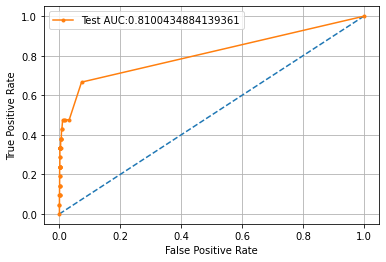

AUC for the model is: 0.8100434884139361


In [124]:
y_scores = rf2smt.predict_proba(X_testv)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_testv, y_scores)
rocauc = roc_auc_score(y_testv, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

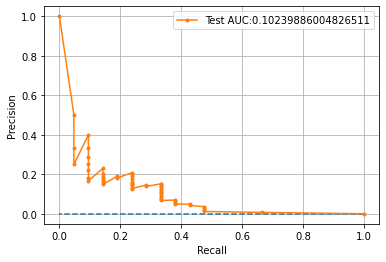

AUC for the model is: 0.10239886004826511


In [123]:
y_scores = rf2smt.predict_proba(X_testv)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testv, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

In [49]:
X_train_smt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199020 entries, 0 to 199019
Data columns (total 10 columns):
date       199020 non-null int64
device     199020 non-null int32
metric1    199020 non-null int64
metric2    199020 non-null int64
metric3    199020 non-null int64
metric4    199020 non-null int64
metric5    199020 non-null int64
metric6    199020 non-null int64
metric8    199020 non-null int64
metric9    199020 non-null int64
dtypes: int32(1), int64(9)
memory usage: 14.4 MB


In [50]:
y_train_smt.failure.value_counts()

1    99510
0    99510
Name: failure, dtype: int64

### Observations:
* With SMOTE upsampling, we get F1=0.1212, with 2 TP.
* The result is still not ideal.
* Let's try a combined method with downsampling the non-failed classes, upsampling the failed classes with SMOTE.

In [51]:
#Let's scan through different downsampling size to find the one with the best F1 score

def sample_size(downsize):
    notfailed_ds2 = resample(notfailed, replace=False, n_samples=downsize, random_state=42)

    y_notfailed_ds2 = notfailed_ds2['failure']
    X_notfailed_ds2 = notfailed_ds2.drop(['failure'],1)

    y_failed = failed['failure']
    X_failed = failed.drop(['failure'],1)

    y_combds = pd.concat([y_failed, y_notfailed_ds2])
    X_combds = pd.concat([X_failed, X_notfailed_ds2])


    #Then use SMOTE to upsample the failed cases to match

    X_train_smt2, y_train_smt2 = smt.fit_sample(X_combds, y_combds)    
    
    X_trainsmt2v = X_train_smt2.values
    y_trainsmt2v = y_train_smt2.values

    rf2smt2 = RandomForestClassifier(random_state=42)
    rf2smt2_clf = rf2smt2.fit(X_trainsmt2v, y_trainsmt2v)
    cv_score = cross_val_score(rf2smt2, X_trainsmt2v, y_trainsmt2v, scoring=scorer, cv=5).mean()
    #print('the mean score of 5 cv sets for the baseline model is:',cv_score)

    y_predsmt2v = rf2smt2.predict(X_testv)
    #print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predsmt2v, labels=[1, 0]))
    #print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predsmt2v, labels=[1, 0], digits=4))
    f1_scores = f1_score(y_testv, y_predsmt2v)
    print('for resampling size {}, f1 score is {}'.format(n, f1_scores))
    return f1_scores

table = {}
for n in range(10000, 98000, 10000):
    f1 = sample_size(n)
    table[n] = f1
print(table)

for resampling size 10000, f1 score is 0.07936507936507936
for resampling size 20000, f1 score is 0.13157894736842107
for resampling size 30000, f1 score is 0.10526315789473685
for resampling size 40000, f1 score is 0.14545454545454542
for resampling size 50000, f1 score is 0.13043478260869565
for resampling size 60000, f1 score is 0.15384615384615383
for resampling size 70000, f1 score is 0.15384615384615383
for resampling size 80000, f1 score is 0.16216216216216214
for resampling size 90000, f1 score is 0.16666666666666666
{10000: 0.07936507936507936, 20000: 0.13157894736842107, 30000: 0.10526315789473685, 40000: 0.14545454545454542, 50000: 0.13043478260869565, 60000: 0.15384615384615383, 70000: 0.15384615384615383, 80000: 0.16216216216216214, 90000: 0.16666666666666666}


In [52]:
#from the scan test, we see the resampling size=90000 gives the best F1 score. Let's downsize the non-failed cases to 90000

notfailed_ds2 = resample(notfailed, replace=False, n_samples=90000, random_state=42)

y_notfailed_ds2 = notfailed_ds2['failure']
X_notfailed_ds2 = notfailed_ds2.drop(['failure'],1)

y_failed = failed['failure']
X_failed = failed.drop(['failure'],1)

y_combds = pd.concat([y_failed, y_notfailed_ds2])
X_combds = pd.concat([X_failed, X_notfailed_ds2])

#Then use SMOTE to upsample the failed cases to match 90000

X_train_smt2, y_train_smt2 = smt.fit_sample(X_combds, y_combds)

print(y_train_smt2.value_counts())

X_trainsmt2v = X_train_smt2.values
y_trainsmt2v = y_train_smt2.values

rf2smt2 = RandomForestClassifier(random_state=42)
rf2smt2_clf = rf2smt2.fit(X_trainsmt2v, y_trainsmt2v)
cv_score = cross_val_score(rf2smt2, X_trainsmt2v, y_trainsmt2v, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

y_predsmt2v = rf2smt2.predict(X_testv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predsmt2v, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predsmt2v, labels=[1, 0], digits=4))

1    90000
0    90000
Name: failure, dtype: int64
the mean score of 5 cv sets for the baseline model is: 0.9995055343339374
The confusion matrix for Random Forest is:
 [[    3    18]
 [   12 24866]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.2000    0.1429    0.9995    0.1667    0.3779    0.1306        21
          0     0.9993    0.9995    0.1429    0.9994    0.3779    0.1550     24878

avg / total     0.9986    0.9988    0.1436    0.9987    0.3779    0.1550     24899



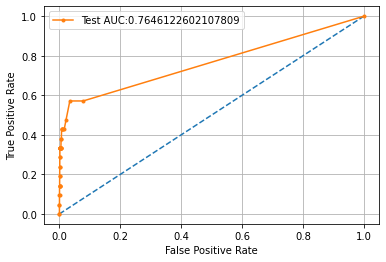

AUC for the model is: 0.7646122602107809


In [63]:
y_scores = rf2smt2.predict_proba(X_testv)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_testv, y_scores)
rocauc = roc_auc_score(y_testv, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)


In [54]:

np.sort(rf2smt2.predict_proba(X_testv)[:,1])[-20:]

array([0.39, 0.41, 0.42, 0.44, 0.47, 0.52, 0.52, 0.55, 0.58, 0.6 , 0.61,
       0.62, 0.71, 0.73, 0.76, 0.82, 0.84, 0.94, 0.98, 0.99])

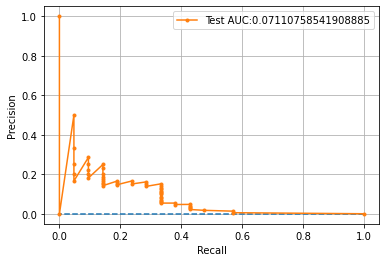

AUC for the model is: 0.07110758541908885


In [121]:
from sklearn import metrics

y_scores = rf2smt2.predict_proba(X_testv)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testv, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

### Observations:
* By scanning through differernt sample number for SMOTE + downsampling, we achieved the best F1 by resampling each class to 90k, with The best F1=1.667.
* All the resampling tested so far are with the same class-data counts. Let's try to test a few more differernt combo options with allowing different class-data counts. 
* The ROC and PR curves look different. They tell different stories, the PR curve focuses on the minority class; whereas the ROC curve covers both classes. We can see PR curve is more suitable for the imbalanced data analysis.

In [59]:
#next, let's find out if allowing different sample number in two classes will help

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_sample(X_train, y_train)
print(y_res.failure.value_counts())


1    85
0    85
Name: failure, dtype: int64


In [60]:
#Scan through different sample ratio to find the optimum setting.

def our_opt(smt, rus):
    smt2 = SMOTE(sampling_strategy=smt/10, random_state=42)
    rus2 = RandomUnderSampler(sampling_strategy=rus/10, random_state=42)
    steps = [('o', smt2), ('u', rus2)]
    pipeline = Pipeline(steps=steps)

    X_train_our, y_train_our = pipeline.fit_resample(X_train, y_train)
    print(y_train_our.failure.value_counts())

    X_trainourv = X_train_our.values
    y_trainourv = y_train_our.values

    rf2our = RandomForestClassifier(random_state=42)
    rf2our_clf = rf2our.fit(X_trainourv, y_trainourv)
    
    y_predourv = rf2our.predict(X_testv)
    f1_scores = f1_score(y_testv, y_predourv)
    print('for smt {} and rus {}, f1 score is {}'.format(smt/10, rus/10, f1_scores))
    return f1_scores

table2 = {}
max = 0
for i in range(1,10,1):
    for j in range(i,10,1):
        f1 = our_opt(i,j)
        table2[f1] = (i/10,j/10)
        if f1 > max:
            max = f1
print(max, table2[max])

0    99510
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.1, f1 score is 0.18181818181818182
0    49755
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.2, f1 score is 0.20512820512820512
0    33170
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.3, f1 score is 0.16326530612244897
0    24877
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.4, f1 score is 0.12903225806451615
0    19902
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.5, f1 score is 0.14705882352941177
0    16585
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.6, f1 score is 0.12048192771084337
0    14215
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.7, f1 score is 0.08988764044943819
0    12438
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.8, f1 score is 0.11965811965811966
0    11056
1     9951
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.1 and rus 0.9, f1 score is 0.09302325581395349
0    99510
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.2, f1 score is 0.18749999999999997
0    66340
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.3, f1 score is 0.23529411764705882
0    49755
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.4, f1 score is 0.18604651162790697
0    39804
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.5, f1 score is 0.1702127659574468
0    33170
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.6, f1 score is 0.14545454545454542
0    28431
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.7, f1 score is 0.13559322033898305
0    24877
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.8, f1 score is 0.11428571428571428
0    22113
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.2 and rus 0.9, f1 score is 0.1388888888888889
0    99510
1    29853
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.3 and rus 0.3, f1 score is 0.17647058823529413
0    74632
1    29853
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.3 and rus 0.4, f1 score is 0.17647058823529413
0    59706
1    29853
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.3 and rus 0.5, f1 score is 0.21052631578947367
0    49755
1    29853
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.3 and rus 0.6, f1 score is 0.17777777777777778
0    42647
1    29853
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.3 and rus 0.7, f1 score is 0.16666666666666666
0    37316
1    29853
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.3 and rus 0.8, f1 score is 0.1509433962264151
0    33170
1    29853
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.3 and rus 0.9, f1 score is 0.10909090909090909
0    99510
1    39804
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.4 and rus 0.4, f1 score is 0.12121212121212123
0    79608
1    39804
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.4 and rus 0.5, f1 score is 0.16216216216216214
0    66340
1    39804
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.4 and rus 0.6, f1 score is 0.21052631578947367
0    56862
1    39804
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.4 and rus 0.7, f1 score is 0.20512820512820512
0    49755
1    39804
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.4 and rus 0.8, f1 score is 0.18604651162790697
0    44226
1    39804
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.4 and rus 0.9, f1 score is 0.17391304347826086
0    99510
1    49755
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.5 and rus 0.5, f1 score is 0.125
0    82925
1    49755
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.5 and rus 0.6, f1 score is 0.16666666666666666
0    71078
1    49755
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.5 and rus 0.7, f1 score is 0.16216216216216214
0    62193
1    49755
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.5 and rus 0.8, f1 score is 0.20512820512820512
0    55283
1    49755
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.5 and rus 0.9, f1 score is 0.2
0    99510
1    59706
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.6 and rus 0.6, f1 score is 0.13333333333333333
0    85294
1    59706
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.6 and rus 0.7, f1 score is 0.17142857142857143
0    74632
1    59706
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.6 and rus 0.8, f1 score is 0.16216216216216214
0    66340
1    59706
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.6 and rus 0.9, f1 score is 0.21052631578947367
0    99510
1    69657
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.7 and rus 0.7, f1 score is 0.12121212121212123
0    87071
1    69657
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.7 and rus 0.8, f1 score is 0.16216216216216214
0    77396
1    69657
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.7 and rus 0.9, f1 score is 0.16666666666666666
0    99510
1    79608
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.8 and rus 0.8, f1 score is 0.12121212121212123
0    88453
1    79608
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.8 and rus 0.9, f1 score is 0.17142857142857143
0    99510
1    89559
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


for smt 0.9 and rus 0.9, f1 score is 0.125
0.23529411764705882 (0.2, 0.3)


In [61]:
#the smt=0.2, rus=0.3 gives best F1 score=0.235, let's try it out


smt2 = SMOTE(sampling_strategy=0.2, random_state=42)
rus2 = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
steps = [('o', smt2), ('u', rus2)]
pipeline = Pipeline(steps=steps)

X_train_our1, y_train_our1 = pipeline.fit_resample(X_train, y_train)
print(y_train_our1.failure.value_counts())

X_trainour1v = X_train_our1.values
y_trainour1v = y_train_our1.values

rf2our1 = RandomForestClassifier(random_state=42)
rf2our1_clf = rf2our1.fit(X_trainour1v, y_trainour1v)
cv_score = cross_val_score(rf2our1, X_trainour1v, y_trainour1v, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

y_predour1v = rf2our1.predict(X_testv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predour1v, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predour1v, labels=[1, 0], digits=4))

0    66340
1    19902
Name: failure, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

the mean score of 5 cv sets for the baseline model is: 0.9967282254386387
The confusion matrix for Random Forest is:
 [[    4    17]
 [    9 24869]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.3077    0.1905    0.9996    0.2353    0.4364    0.1750        21
          0     0.9993    0.9996    0.1905    0.9995    0.4364    0.2058     24878

avg / total     0.9987    0.9990    0.1912    0.9988    0.4364    0.2058     24899



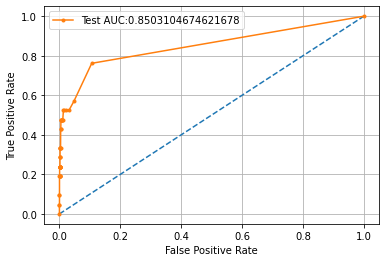

AUC for the model is: 0.8503104674621678


In [129]:
y_scores = rf2our1.predict_proba(X_testv)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_testv, y_scores)
rocauc = roc_auc_score(y_testv, y_scores)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr,tpr,marker='.', label='Test AUC:' + str(rocauc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',rocauc)

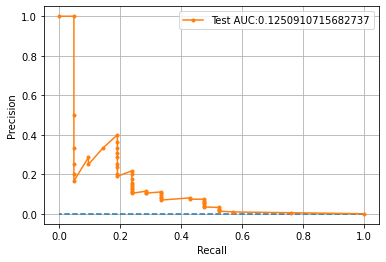

AUC for the model is: 0.1250910715682737


In [145]:
y_scores = rf2our1.predict_proba(X_testv)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testv, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

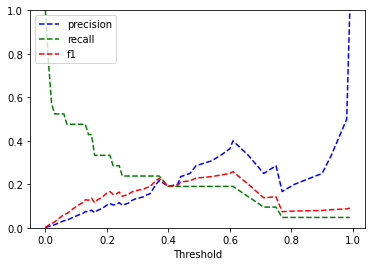

In [146]:
def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()

In [88]:
features1 = pd.DataFrame()
features1['feature'] = X_train_our1.columns
features1['importance'] = rf2our1.feature_importances_
features1.sort_values(by='importance').tail(15)

,feature,importance
4,metric3,0.005856
9,metric9,0.012078
6,metric5,0.043257
1,device,0.045333
0,date,0.046908
2,metric1,0.054930
7,metric6,0.057166
5,metric4,0.214195
8,metric8,0.239404
3,metric2,0.280872


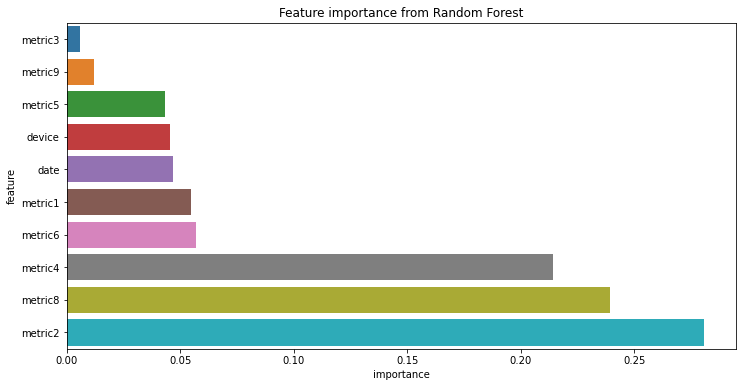

In [89]:
fig = plt.figure(figsize=(12,6))
sns.barplot(x=features1['importance'], y=features1['feature'], order=features1.sort_values('importance').feature)
plt.title('Feature importance from Random Forest')
plt.show()

### Observations:
* With combined SMOTE + downsampling, the best result we get is F1=0.2353 with smt=0.2, rus=0.3
* We will proceed with this sampling setting.

## Summary
* After testing and comparing different resampling methods:
    1. Upsampling the minority
    2. Downsampling the majority
    3. SMOTE synthetic upsampling
    4. Combo of SMOTE and majority downsampling
* we chose to resample the imblanced data: with smt=0.2, rus=0.3

# 4. Feature Engineering and Feature Selection
* We attempt to conceptually describe and abstract a device’s health condition at a given time using historical data collected up to that point in time.

* Assuming there may be some time series relationship between the data points. 
    - For tree-based algorithms, we will try to create some new features that preserve the time sequence impact at any given time. 
    - For the later LSTM, the algorithm will build a long-term memory within a defined time step window.

* The new features created includes:
    - Moving average
    - Moving standard deviation
    - Total running time
    - Metric difference from reference

* The further feature processing includes:
    - Test of converting the categorical features to numerical features: Label encoder, Target encoder.
    - Test of moving window size for aggregating. (Time step for LSTM)
    - Test of binning the device into different groups. (assume device may be grouped by specs)
    - Analyze the multicollinearity, variance and correlation among features to conduct feature selection.


In [66]:
#1, only keep metric8 as it is the same as metric7
prep_input = raw_input.copy()
prep_input.drop('metric7', axis=1, inplace=True)

In [112]:
#2, add a feature to indicate the running time for each device: runningtime = current date - first recorded date
prep_input['starttime'] = prep_input.groupby(['device']).date.transform('min')
prep_input['runningtime'] = prep_input['date'] - prep_input['starttime']
prep_input.head(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,...,metric2diff,metric4_st,metric4diff,metric5_st,metric5diff,metric6_st,metric6diff,metric8_st,metric8diff,device_comb
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,...,56,0,52,1,5,8,407430,0,0,S1F01
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,...,0,0,0,1,5,8,403166,0,0,S1F01
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,...,0,0,0,1,11,8,237386,0,0,S1F01
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,...,0,0,0,1,5,8,410178,0,0,S1F01
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,...,0,0,0,1,14,8,313165,0,0,S1F01


In [68]:
#3, add features of moving average to preserve time series information for all metrics except metric1(it is just oscilating), metric3 and 9(they are not changing).

metric_process = ['metric1', 'metric2', 'metric4', 'metric5', 'metric6', 'metric8']
for each in metric_process:
    prep_input[each + '_ma15'] = round(prep_input[each].rolling(window=10, min_periods=1).mean(),0)
    #prep_input[each + '_msd15'] = round(prep_input[each].rolling(window=3, min_periods=1).apply(lambda x: pd.np.std(x)),1)


prep_input.sample(6)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,starttime,runningtime,metric1_ma15,metric2_ma15,metric4_ma15,metric5_ma15,metric6_ma15,metric8_ma15
70737,2015-04-15,W1F0JH87,0,28450376,0,1,0,9,255075,0,0,2015-01-01,104 days,125361390.0,0.0,0.0,34.0,259430.0,0.0
93875,2015-06-18,W1F14XGD,0,140233920,2448,0,0,12,241241,0,0,2015-01-01,168 days,99892952.0,245.0,22.0,11.0,281287.0,0.0
41018,2015-02-23,W1F1DN0Y,0,66646536,0,0,0,24,244468,0,0,2015-01-01,53 days,144459554.0,0.0,0.0,12.0,110380.0,0.0
48686,2015-03-07,S1F0S4EG,0,3735288,0,0,0,6,261772,0,0,2015-01-01,65 days,100168319.0,3.0,1.0,9.0,232825.0,0.0
48431,2015-03-06,W1F1MRP9,0,179663656,0,0,0,6,228838,0,0,2015-01-01,64 days,95605204.0,0.0,0.0,10.0,72872.0,0.0
89527,2015-06-06,S1F0TP5E,0,159469600,0,2693,0,12,295315,0,2522,2015-01-01,156 days,134595562.0,74.0,0.0,11.0,268427.0,0.0


In [69]:
#4, add difference between the current time metrics and the start time metrics for the metric2, 4, 5, 6, 8
prep_input['metric2_st'] = prep_input.groupby(['starttime']).metric2.transform('min')
prep_input['metric2diff'] = prep_input['metric2'] - prep_input['metric2_st']
prep_input['metric4_st'] = prep_input.groupby(['starttime']).metric4.transform('min')
prep_input['metric4diff'] = prep_input['metric4'] - prep_input['metric4_st']
prep_input['metric5_st'] = prep_input.groupby(['starttime']).metric5.transform('min')
prep_input['metric5diff'] = prep_input['metric5'] - prep_input['metric5_st']
prep_input['metric6_st'] = prep_input.groupby(['starttime']).metric6.transform('min')
prep_input['metric6diff'] = prep_input['metric6'] - prep_input['metric6_st']
prep_input['metric8_st'] = prep_input.groupby(['starttime']).metric8.transform('min')
prep_input['metric8diff'] = prep_input['metric8'] - prep_input['metric8_st']
prep_input.sample(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,...,metric2_st,metric2diff,metric4_st,metric4diff,metric5_st,metric5diff,metric6_st,metric6diff,metric8_st,metric8diff
109872,2015-08-04,W1F0KG97,0,191345544,0,0,0,68,251081,0,...,0,0,0,0,1,67,8,251073,0,0
103783,2015-07-17,S1F1162D,0,63945736,0,0,0,7,266785,0,...,0,0,0,0,1,6,8,266777,0,0
95437,2015-06-23,S1F0M2PQ,0,123980568,0,0,6,60,251226,0,...,0,0,0,6,1,59,8,251218,0,0
23432,2015-01-29,W1F1CL1K,0,67631000,0,0,112,17,341966,0,...,0,0,0,112,1,16,8,341958,0,0
51619,2015-03-11,W1F0MNDQ,0,197500360,0,0,0,7,205684,0,...,0,0,0,0,1,6,8,205676,0,0


In [70]:
#5, Different devices have different metric pattern, we definitely need to use the device as a feature to train the model
#we will try to group the devices by the common name of the first portion
raw_input.device.unique()

array(['S1F01085', 'S1F0166B', 'S1F01E6Y', ..., 'S1F02XLX', 'S1F03499',
       'W1F1DA5ÿ'], dtype=object)

In [71]:
#we are not which way to group the devices is better: 
# if we group by the first 5 common letters, we will have 121 groups; 
# if we group by the first 4 common letters, we will have only 5 groups, let's try this option first.

temp_dev = []
for each in raw_input.device.values:
    each = each[:5]
    temp_dev.append(each)
prep_input['device_comb'] = temp_dev
prep_input.sample(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,...,metric2diff,metric4_st,metric4diff,metric5_st,metric5diff,metric6_st,metric6diff,metric8_st,metric8diff,device_comb
100732,2015-07-08,S1F135DG,0,28602504,0,0,0,11,237422,0,...,0,0,0,1,10,8,237414,0,0,S1F13
30710,2015-02-08,Z1F1A0RP,0,38997656,0,0,0,7,197767,0,...,0,0,0,1,6,8,197759,0,0,Z1F1A
117176,2015-09-01,W1F1CL1K,0,139851104,0,0,112,20,376564,0,...,0,0,112,1,19,8,376556,0,0,W1F1C
12511,2015-01-14,S1F13MAM,0,108961848,0,0,0,8,237052,0,...,0,0,0,1,7,8,237044,0,0,S1F13
10412,2015-01-11,W1F0X7P2,0,15074856,0,0,0,13,230731,0,...,0,0,0,1,12,8,230723,0,0,W1F0X


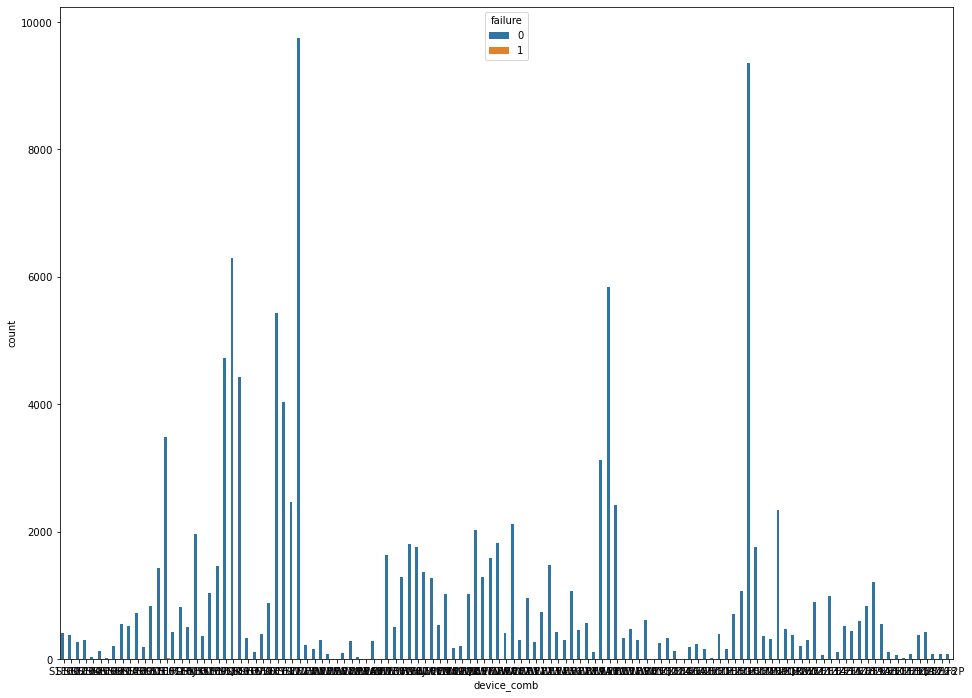

In [72]:
#how does the failure distribution vs new device groups
plt.figure(figsize=(16, 12))
sns.countplot(x=prep_input.device_comb, hue=prep_input.failure)

In [73]:
prep_fail_ck = prep_input.groupby('device_comb').agg({'failure':[np.size,np.sum]})
prep_fail_ck.sort_values(by=[('failure','sum'), ('failure','size')], ascending=[False, True])

failure    
               size sum
device_comb            
S1F0G          3488   7
S1F0S          6302   6
S1F0L          1966   5
W1F1C          5841   5
W1F0T          2022   4
S1F13          9758   4
S1F0J           815   3
W1F0P          1021   3
W1F0F          1634   3
W1F0Z          2114   3
W1F1B          3124   3
S1F0R          4720   3
Z1F0L          9364   3
W1F03           163   2
Z1F0P           322   2
Z1F14           997   2
S1F0P          1034   2
W1F0M          1275   2
S1F0Q          1454   2
Z1F0M          1765   2
W1F0X          1825   2
S1F0T          4425   2
Z1F13            64   1
Z1F1F            67   1
W1F08            96   1
Z1F04           132   1
Z1F0F           162   1
W1F0Q           175   1
S1F0D           187   1
S1F09           209   1
...             ...  ..
W1F05           304   0
Z1F02           324   0
S1F0V           326   0
W1F1F           329   0
S1F0M           366   0
Z1F0V           379   0
S1F0X           398   0
Z1F0E           398   0
W1F0Y           400   0
S1F01           407   0
S1F0H           427   0
Z1F17           441   0
W1F18           456   0
W1F1G           466   0
Z1F0R           472   0
S1F0K           497   0
S1F0B           524   0
Z1F1B           543   0
S1F0A           552   0
Z1F18           590   0
W1F1N           605   0
Z1F0G           705   0
S1F0E           823   0
S1F0Y           882   0
Z1F11           888   0
W1F17          1072   0
W1F0H          1288   0
W1F0L          1370   0
W1F0J          1797   0
S1F12          2466   0

[121 rows x 2 columns]

In [74]:
#6, feed all the features into Random Forest again, to check the result and feature importance
phase1_input = prep_input.copy()
phase1_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 30 columns):
date            124494 non-null datetime64[ns]
device          124494 non-null object
failure         124494 non-null int64
metric1         124494 non-null int64
metric2         124494 non-null int64
metric3         124494 non-null int64
metric4         124494 non-null int64
metric5         124494 non-null int64
metric6         124494 non-null int64
metric8         124494 non-null int64
metric9         124494 non-null int64
starttime       124494 non-null datetime64[ns]
runningtime     124494 non-null timedelta64[ns]
metric1_ma15    124494 non-null float64
metric2_ma15    124494 non-null float64
metric4_ma15    124494 non-null float64
metric5_ma15    124494 non-null float64
metric6_ma15    124494 non-null float64
metric8_ma15    124494 non-null float64
metric2_st      124494 non-null int64
metric2diff     124494 non-null int64
metric4_st      124494 non-null int64
metric4diff 

In [75]:

te = ce.TargetEncoder()
phase1_input['deivce_enc'] = le.fit_transform(phase1_input['device_comb'])
#phase1_input['device_enc'] = te.fit_transform(phase1_input['device'], phase1_input['failure'])
phase1_input['date'] = phase1_input['date'].dt.dayofyear
phase1_input['starttime'] = phase1_input['starttime'].dt.dayofyear
phase1_input['runningtime'] = phase1_input['runningtime'].dt.days
phase1_input.drop(['device'],1,inplace=True)
phase1_input.drop(['device_comb'],1,inplace=True)
phase1_input.sample()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,...,metric2diff,metric4_st,metric4diff,metric5_st,metric5diff,metric6_st,metric6diff,metric8_st,metric8diff,deivce_enc
120583,267,0,131259768,0,0,0,7,329016,0,0,...,0,0,0,1,6,8,329008,0,0,91


In [76]:
#split the data with imbalanced classes with stratified sampling
phase1_X = phase1_input.drop(['failure'],1)
phase1_y = phase1_input[['failure']]
X_trainp1, X_testp1, y_trainp1, y_testp1 = train_test_split(phase1_X, phase1_y, train_size=0.8, random_state=42, stratify=base_y)

In [77]:
#dowsample the majority just as what we did in base line stage

smt2 = SMOTE(sampling_strategy=0.2, random_state=42)
rus2 = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
steps = [('o', smt2), ('u', rus2)]
pipeline = Pipeline(steps=steps)

X_train_our2, y_train_our2 = pipeline.fit_resample(X_trainp1, y_trainp1)
#print(y_train_our2.failure.value_counts())

X_trainour2v = X_train_our2.values
y_trainour2v = y_train_our2.values

rf2our2 = RandomForestClassifier(random_state=42)
rf2our2_clf = rf2our2.fit(X_trainour2v, y_trainour2v)
cv_score = cross_val_score(rf2our2, X_trainour2v, y_trainour2v, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

X_testp1v = X_testp1.values
y_testp1v = y_testp1.values
y_predour2v = rf2our2.predict(X_testp1v)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testp1v, y_pred=y_predour2v, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testp1v, y_pred=y_predour2v, labels=[1, 0], digits=4))

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was 

the mean score of 5 cv sets for the baseline model is: 0.9973817202139541
The confusion matrix for Random Forest is:
 [[    3    18]
 [    9 24869]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.2500    0.1429    0.9996    0.1818    0.3779    0.1306        21
          0     0.9993    0.9996    0.1429    0.9995    0.3779    0.1550     24878

avg / total     0.9986    0.9989    0.1436    0.9988    0.3779    0.1550     24899



### summary
1. average for 20 days: F1=0.1667, AUC=0.1562 /LE  F1=0.1250  AUC=0.0586
2. average for 15 days: F1=0.2222, AUC=0.1834 /LE  F1=0.1818  AUC=0.0688
3. average for 10 days: F1=0.2353, AUC=0.1297 /LE  F1=0.1818  AUC=0.1072
4. average for 5 days: F1=0.1714, AUC=0.1638  /LE  F1=0.1622  AUC=0.0803

5. average for 10 days, device_comb by first 6 digit: F1=0.1765  AUC=0.0874
6. average for 10 days, device_comb by first 5 digit: F1=0.1818  AUC=0.1078
7. average for 10 days, device_comb by first 4 digit: F1=0.1714  AUC=0.0794


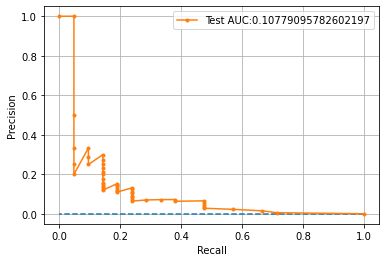

AUC for the model is: 0.10779095782602197


In [143]:
y_scores = rf2our2.predict_proba(X_testp1v)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testp1v, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

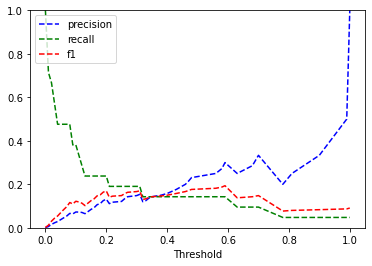

In [144]:
def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()

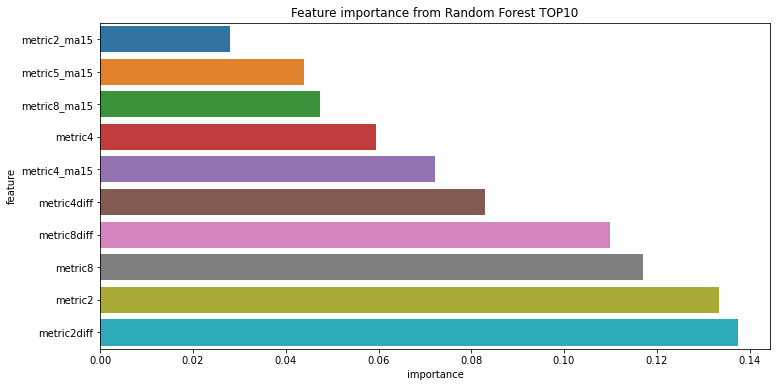

In [148]:
#print the feature importance
features0 = pd.DataFrame()
features0['feature'] = X_train_our2.columns
features0['importance'] = rf2our2.feature_importances_
features0 = features0.sort_values(by='importance').tail(10)

fig = plt.figure(figsize=(12,6))
sns.barplot(x=features0['importance'], y=features0['feature'], order=features0.sort_values('importance').feature)
plt.title('Feature importance from Random Forest TOP10')
plt.show()

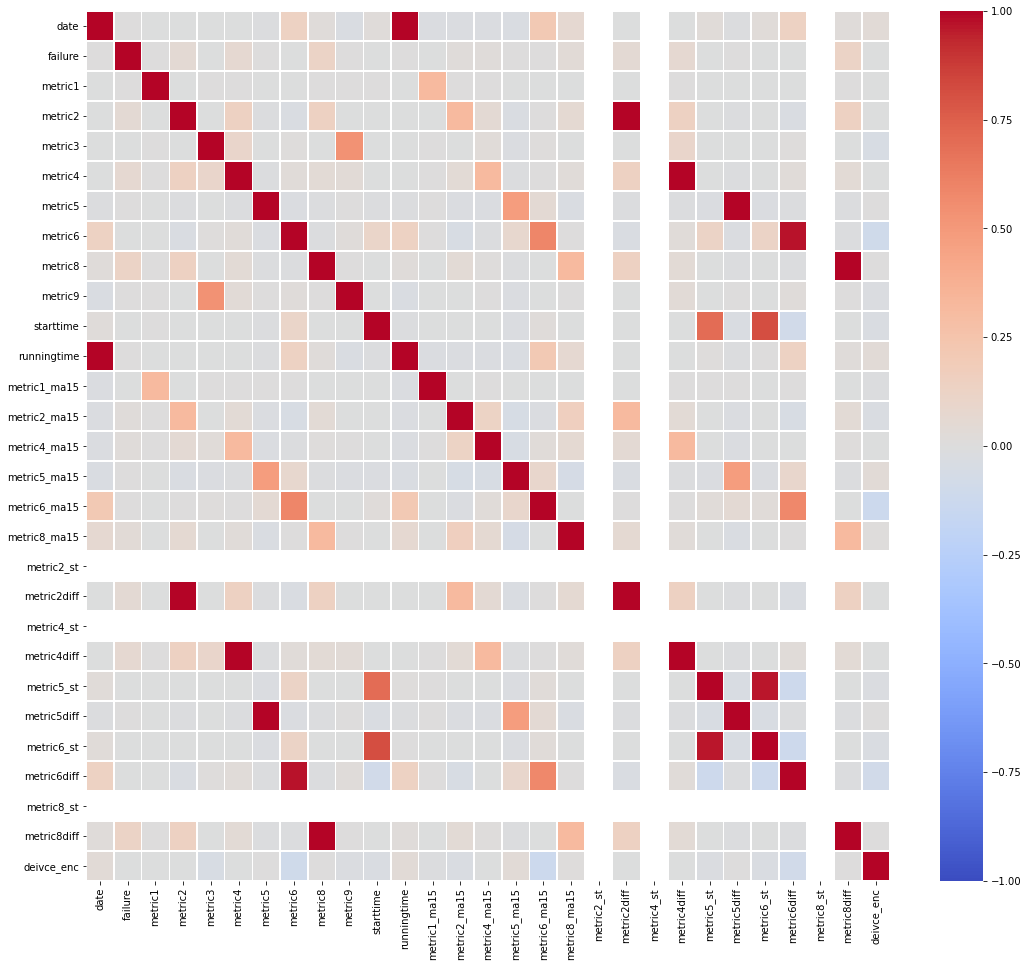

In [79]:
#let's plot the correlation heap map to check for multicollinearity issue
corrp1 = phase1_input.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corrp1, cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

### Observation:
Adding additional time series features introduces multicolnearity issue, we will conduct feature selection based on:
    - feature collinearity
    - feature variance
    - feature correlation with the target

In [80]:
phase1_input.metric5_st.unique()

array([ 1,  8,  5, 15], dtype=int64)

In [81]:
phase1_input.metric2_st.unique()

array([0], dtype=int64)

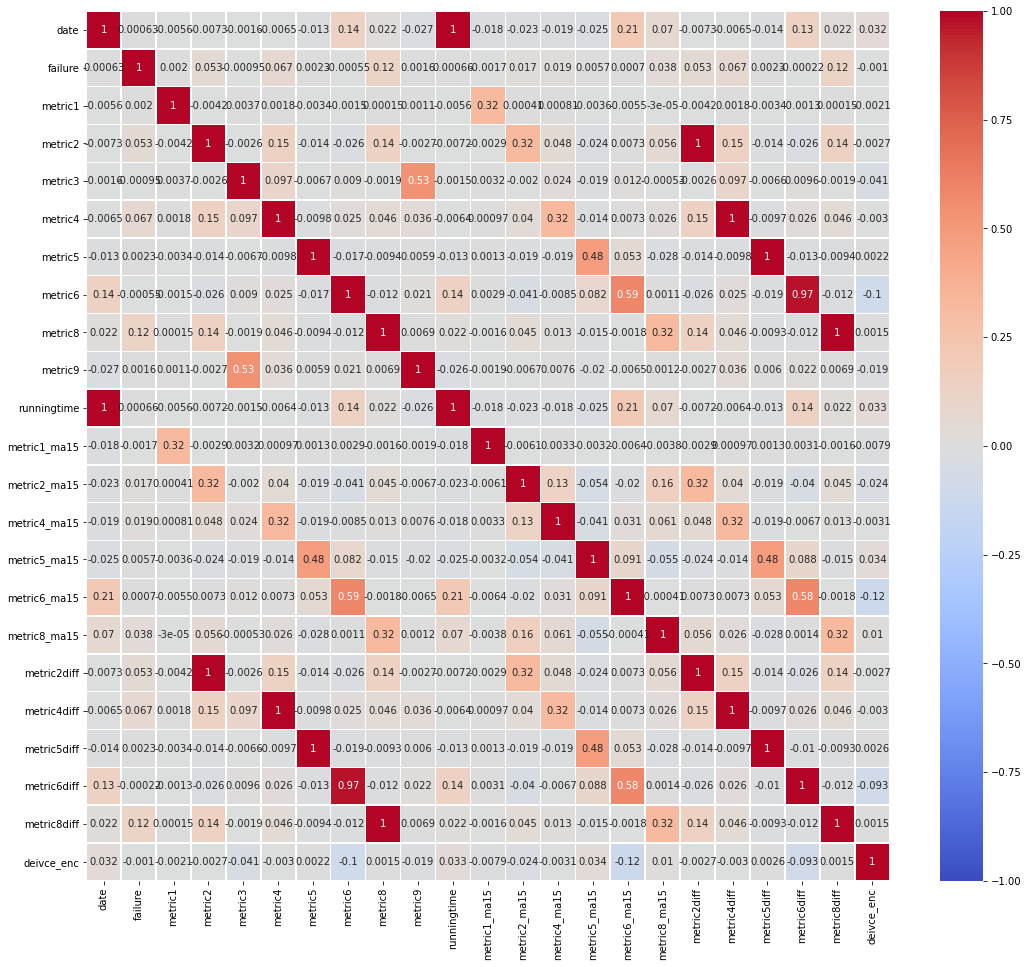

In [82]:
phase1_subset = phase1_input.drop(['starttime', 'metric2_st', 'metric4_st', 'metric5_st', 'metric6_st', 'metric8_st'],1)
corrp1sub = phase1_subset.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corrp1sub, cmap='coolwarm', linewidth=.5, annot=True, vmin=-1, vmax=1)

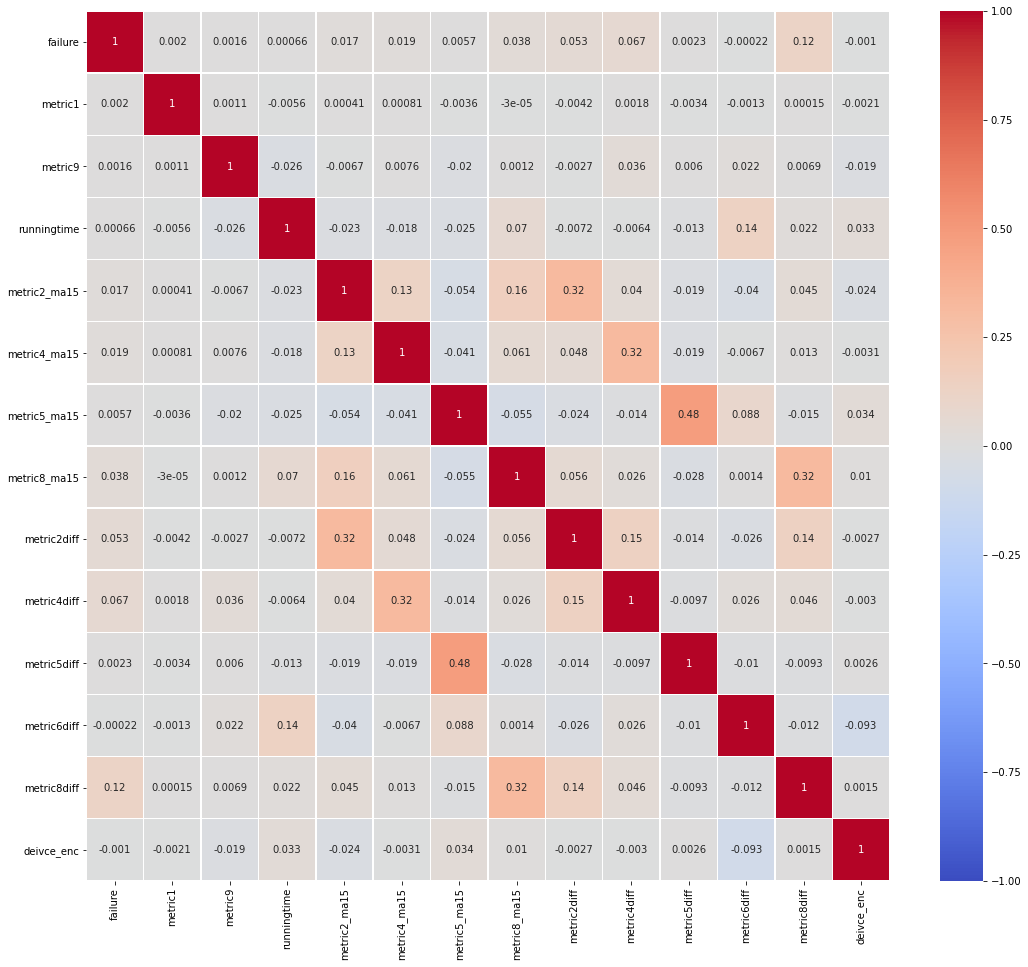

In [94]:
#feature selection: 1, remove features with low variance; 2, remove features with high colinearity; 3, keep the features with high correlation with target
phase1_subset2 = phase1_subset.drop(['date', 'metric2', 'metric4', 'metric8', 'metric1_ma15', 'metric5', 'metric6', 'metric6_ma15', 'metric3'],1)
corrp1sub2 = phase1_subset2.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corrp1sub2, cmap='coolwarm', linewidth=.5, annot=True, vmin=-1, vmax=1)

In [95]:
phase1s2_X = phase1_subset2.drop(['failure'],1)
phase1s2_y = phase1_subset2[['failure']]
X_trainp1s2, X_testp1s2, y_trainp1s2, y_testp1s2 = train_test_split(phase1s2_X, phase1s2_y, train_size=0.8, random_state=42, stratify=base_y)

In [96]:
X_trainp1s2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99595 entries, 73169 to 1901
Data columns (total 13 columns):
metric1         99595 non-null int64
metric9         99595 non-null int64
runningtime     99595 non-null int64
metric2_ma15    99595 non-null float64
metric4_ma15    99595 non-null float64
metric5_ma15    99595 non-null float64
metric8_ma15    99595 non-null float64
metric2diff     99595 non-null int64
metric4diff     99595 non-null int64
metric5diff     99595 non-null int64
metric6diff     99595 non-null int64
metric8diff     99595 non-null int64
deivce_enc      99595 non-null int32
dtypes: float64(4), int32(1), int64(8)
memory usage: 10.3 MB


In [97]:
#After hand-pick a subset of features, let's fit into the resampled data and try the model

X_train_our2s2, y_train_our2s2 = pipeline.fit_resample(X_trainp1s2, y_trainp1s2)
#print(y_train_our2.failure.value_counts())

X_trainour2vs2 = X_train_our2s2.values
y_trainour2vs2 = y_train_our2s2.values

rf2our2s2 = RandomForestClassifier(random_state=42)
rf2our2s2_clf = rf2our2s2.fit(X_trainour2vs2, y_trainour2vs2)
cv_score = cross_val_score(rf2our2s2, X_trainour2vs2, y_trainour2vs2, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

X_testp1vs2 = X_testp1s2.values
y_testp1vs2 = y_testp1s2.values
y_predour2vs2 = rf2our2s2.predict(X_testp1vs2)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testp1vs2, y_pred=y_predour2vs2, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testp1vs2, y_pred=y_predour2vs2, labels=[1, 0], digits=4))

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

the mean score of 5 cv sets for the baseline model is: 0.9973277067877191
The confusion matrix for Random Forest is:
 [[    3    18]
 [   10 24868]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.2308    0.1429    0.9996    0.1765    0.3779    0.1306        21
          0     0.9993    0.9996    0.1429    0.9994    0.3779    0.1550     24878

avg / total     0.9986    0.9989    0.1436    0.9987    0.3779    0.1550     24899



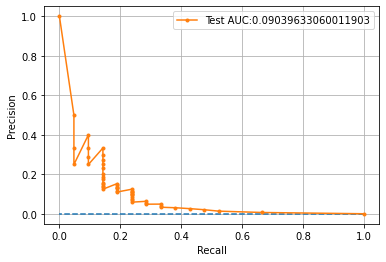

AUC for the model is: 0.09039633060011903


In [141]:
y_scores = rf2our2s2.predict_proba(X_testp1vs2)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testp1vs2, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

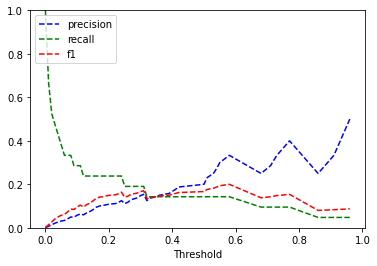

In [142]:
def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()

In [99]:
target = 1 # class you want to plot
scorer = make_scorer(lambda y_true, y_pred: f1_score(
    y_true, y_pred, 
    labels=None, 
    pos_label=target,  
    sample_weight=None))

X_train_our2s2, y_train_our2s2 = pipeline.fit_resample(X_trainp1s2, y_trainp1s2)
#print(y_train_our2.failure.value_counts())

X_trainour2vs2 = X_train_our2s2.values
y_trainour2vs2 = y_train_our2s2.values

#rf2our2s2 = RandomForestClassifier(random_state=42)
#rf2our2s2_clf = rf2our2s2.fit(X_trainour2vs2, y_trainour2vs2)
cv_score = cross_val_score(rf2our2s2, X_trainour2vs2, y_trainour2vs2, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the baseline model is:',cv_score)

y_trpredour2vs2 = rf2our2s2.predict(X_trainour2vs2)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_trainour2vs2, y_pred=y_trpredour2vs2, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_trainour2vs2, y_pred=y_trpredour2vs2, labels=[1, 0], digits=4))


b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was pa

the mean score of 5 cv sets for the baseline model is: 0.9973277067877191
The confusion matrix for Random Forest is:
 [[19902     0]
 [    0 66340]]
                   pre       rec       spe        f1       geo       iba       sup

          1     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000     19902
          0     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000     66340

avg / total     1.0000    1.0000    1.0000    1.0000    1.0000    1.0000     86242



In [100]:
#print the feature importance
features2 = pd.DataFrame()
features2['feature'] = X_train_our2s2.columns
features2['importance'] = rf2our2s2_clf.feature_importances_
features2.sort_values(by='importance').tail(15)

,feature,importance
1,metric9,0.007038
9,metric5diff,0.020245
12,deivce_enc,0.024003
0,metric1,0.031098
10,metric6diff,0.031232
2,runningtime,0.032989
5,metric5_ma15,0.056264
3,metric2_ma15,0.060393
6,metric8_ma15,0.086665
4,metric4_ma15,0.091352


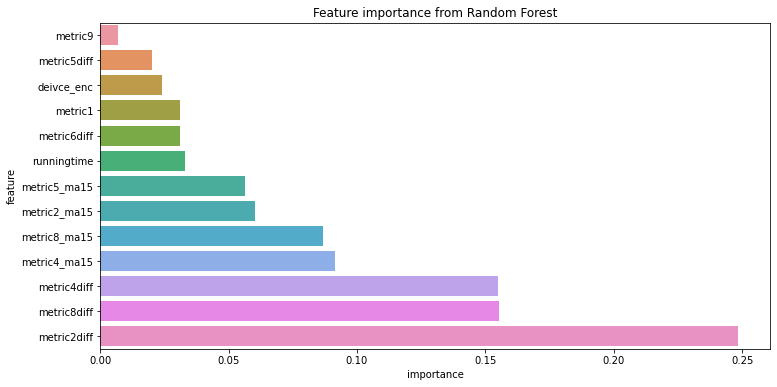

In [101]:
fig = plt.figure(figsize=(12,6))
sns.barplot(x=features2['importance'], y=features2['feature'], order=features2.sort_values('importance').feature)
plt.title('Feature importance from Random Forest')
plt.show()

## Summary
The model after a series of feature engineering improves the CV score for the training set. However, it doesn’t beat the baseline model on test set prediction in both F1 and PR-AUC. 

Without further testing other feature engineering and feature selection techniques due to the limit of time, we will choose the baseline features to proceed.



# 5. Modeling
* Two ensemble tree-based algorithms were tested with hyperparameter tuning:
    - Random Forest with RandomSearchCV for optimizing hyperparameters.
    - XGBoost with Hyperopt for optimizing the hyperparameters.

* One deep learning algorithm was tested with hyperparameter tuning:
    - LSTM with RandomSearchCV for optimizing hyperparameters.
    - Different split methods, resampling strategy and feature engineering were tested for LSTM separately.


## 5.1 Random Forest tuning

In [117]:
#define a grid for RandomizedSearchCV to find the optimum hyperparamerters.
n_estimators = [int(x) for x in np.linspace(50, 1500, 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, scoring=scorer, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_trainour1v, y_trainour1v)    
print(rf_random.best_params_, rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 65.2min finished
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 660, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 26, 'bootstrap': False} 0.9972081249392463


In [132]:
rf5 = RandomForestClassifier(n_estimators=660, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=26, bootstrap=False, random_state=42)
#rf5 = RandomForestClassifier(random_state=42)
rf5_clf = rf5.fit(X_trainour1v, y_trainour1v)
cv_score = cross_val_score(rf5, X_trainour1v, y_trainour1v, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the phase1 model is:',cv_score)

y_predp1vs2t = rf5.predict(X_testv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predp1vs2t, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predp1vs2t, labels=[1, 0], digits=4))

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
b:\program files\phthon\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-

the mean score of 5 cv sets for the phase1 model is: 0.997156137213645
The confusion matrix for Random Forest is:
 [[    3    18]
 [   11 24867]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.2143    0.1429    0.9996    0.1714    0.3779    0.1306        21
          0     0.9993    0.9996    0.1429    0.9994    0.3779    0.1550     24878

avg / total     0.9986    0.9988    0.1436    0.9987    0.3779    0.1550     24899



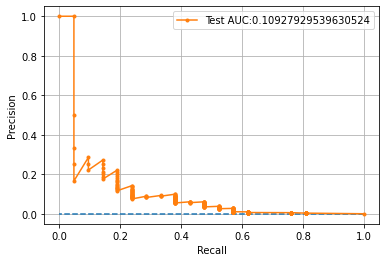

AUC for the model is: 0.10927929539630524


In [139]:
y_scores = rf5.predict_proba(X_testv)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testv, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

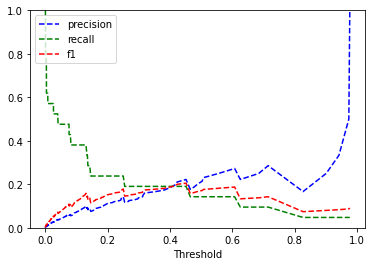

In [140]:
def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()

In [ ]:
#Before resampling the input data, we tested to scan the class_weight for the RF algorithm, it suggest 1:4 for the best F1 score. Let's double check it again to see if it's still needed
w_neg = 1
w_pos_range = np.arange(1,10)

In [ ]:
def confusion(classifier, X_test, y_test):
    y_pred  = classifier.predict(X_test)
    return confusion_matrix(y_test, y_pred).ravel()

def show(tn,fp,fn,tp):
    print("TN:" + str(tn) + " FP:" + str(fp) + " FN:" + str(fn) + " TP:" + str(tp) + 
          " TPR=" + str(tp/(tp+fn)) + " FPR=" + str(fp/(fp+tn)) + ' precision=' + str(tp/(tp+fp)) + ' f1=' + str(2*(tp/(tp+fn))*(tp/(tp+fp))/(tp/(tp+fn)+tp/(tp+fp))))

In [ ]:
for w_pos in w_pos_range:
    print("w_pos: " + str(w_pos))
    show(*confusion(RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10, class_weight={0: w_neg, 1: w_pos}).fit(X_trainour2vs2, y_trainour2vs2),X_testp1vs2,y_testp1vs2))

### observation:
* After resampling the input data, the class_weight is no longer needed.
* The RF after tuning improves the performance on the training set and CV set, but not on the test set. the model is likely overfitted.

## 5.2 XGBoost tuning

In [120]:
#define a grid for Hyperopt to find the optimum hyperparamerters.

space = {'n_estimators': hp.quniform('n_estimators', 300, 4000, 100),
         'gamma' : hp.uniform('gamma', 0.01, 0.1),
         'learning_rate': hp.uniform('learning_rate', 0.0001, 0.05),
         'max_depth': hp.quniform('max_depth', 3, 15, 1),
         'subsample': hp.uniform('subsample', 0.3, 1),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def Xgbtuning(space):
    
    reg = xgb.XGBClassifier(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'], learning_rate=space['learning_rate'], reg_lambda=space['reg_lambda'], subsample=space['subsample'])
    ##reg.fit(features, target, eval_set=evaluation, eval_metric="rmse",early_stopping_rounds=10,verbose=False)  need training/test set to evaluate the early stopping, since we are using hyperopt to evaluate the hyperparamerters
    #reg.fit(features, target)
    cvscore = model_selection.cross_val_score(reg, X_trainour1v, y_trainour1v, scoring=scorer, cv=5, n_jobs=-1).mean()
    #print(cvscore)
    return -cvscore
#Xgbtuning(space)

best = fmin(fn=Xgbtuning, space=space, max_evals=20, rstate=np.random.RandomState(42), algo=tpe.suggest, trials=Trials())
print(best)

100%|████| 20/20 [1:50:28<00:00, 331.43s/trial, best loss: -0.9977159265737449]
{'gamma': 0.025659255025665177, 'learning_rate': 0.03989219624342907, 'max_depth': 7.0, 'n_estimators': 3400.0, 'reg_lambda': 1.250477677119223, 'subsample': 0.6689768654226249}


In [136]:
##XGBoost after getting the best hyperparameters:

xgboost = xgb.XGBClassifier(gamma=0.0257, learning_rate=0.0399, max_depth=7, n_estimators=3400, reg_lambda=1.2505, subsample=0.6690)
xgb_fit = xgboost.fit( X_trainour1v, y_trainour1v, eval_metric='aucpr', verbose=True)
cv_score = cross_val_score(xgboost, X_trainour1v, y_trainour1v, scoring=scorer, cv=5).mean()
print('the mean score of 5 cv sets for the phase1 model is:',cv_score)

y_predp1vs2xg = xgboost.predict(X_testv)
print('The confusion matrix for Random Forest is:\n', confusion_matrix(y_true=y_testv, y_pred=y_predp1vs2xg, labels=[1, 0]))
print(classification_report_imbalanced(y_true=y_testv, y_pred=y_predp1vs2xg, labels=[1, 0], digits=4))

b:\program files\phthon\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
b:\program files\phthon\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


the mean score of 5 cv sets for the phase1 model is: 0.9977153907165883
The confusion matrix for Random Forest is:
 [[    2    19]
 [   13 24865]]
                   pre       rec       spe        f1       geo       iba       sup

          1     0.1333    0.0952    0.9995    0.1111    0.3085    0.0866        21
          0     0.9992    0.9995    0.0952    0.9994    0.3085    0.1038     24878

avg / total     0.9985    0.9987    0.0960    0.9986    0.3085    0.1038     24899



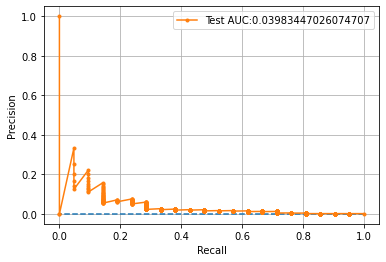

AUC for the model is: 0.03983447026074707


In [135]:
y_scores = xgboost.predict_proba(X_testv)
y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(y_testv, y_scores)
pr_auc = metrics.auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


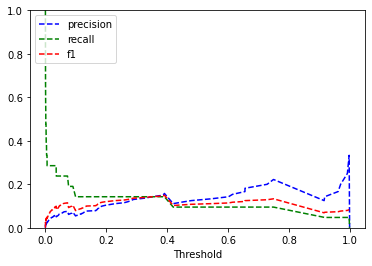

In [138]:
def plot_prec_recall_thre(precisions, recalls, thresholds):
    f1_ = 2*recalls*precisions/(recalls+precisions)
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.plot(thresholds, f1_[:-1], 'r--', label = 'f1')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_thre(prec, recall, thresholds)
plt.show()

### observation:
* The XGBoost after tuning improves the performance on the training set and CV set, but not on the test set. the model is likely overfitted.

## 5.3 Deep Neural Networks: LSTM
LSTM network models are a type of recurrent neural network that are able to learn and remember over long sequences of input data.The benefit of using LSTMs for sequence classification is that they can learn from the raw time series data directly, and in turn do not require domain expertise to manually engineer input features. The model can learn an internal representation of the time series data and ideally achieve comparable performance to models fit on a version of the dataset with engineered features。

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier

### 5.3.1 LSTM input data preparation

In [6]:
#data precessing, assume LSTM only requires minimum feature engineering, we only drop the duplicates here.
prep2_input = raw_input.copy()
prep2_input.drop_duplicates()
prep2_input.drop('metric7', axis=1, inplace=True)

prep2_input.tail(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0


In [7]:
phase2_input = prep2_input.copy()

te = ce.TargetEncoder()
le = LabelEncoder()
phase2_input['device_enc'] = le.fit_transform(phase2_input['device'])
phase2_input['date'] = phase2_input['date'].dt.dayofyear
#phase2_input['starttime'] = phase2_input['starttime'].dt.dayofyear
#phase2_input['runningtime'] = phase2_input['runningtime'].dt.days

## split method1: split by device portion

'''split_ratio = 0.8
trainp2 = pd.DataFrame()
testp1 = pd.DataFrame()
for each in phase2_input.device.unique():
    count = phase2_input[phase2_input['device'] == each].date.nunique()
    cutoff = int(split_ratio*count)
    trainp2 = trainp2.append(phase2_input.loc[phase2_input['device'] == each][0:cutoff])
    testp1 = testp1.append(phase2_input.loc[phase2_input['device'] == each][cutoff:])
'''

## split method2: split by date:

'''phase2_input.sort_values(by=['date','device'])
split_ratio = 0.8
cutoff = int(split_ratio*len(phase2_input))
trainp2 = phase2_input[0:cutoff]
testp1 = phase2_input[cutoff:]
'''

## split method3: split by device:

phase2_input = phase2_input.sort_values(by=['device', 'date'])
split_ratio = 0.8
cutoff = int(split_ratio*len(phase2_input))
trainp1 = phase2_input[0:cutoff]
testp1 = phase2_input[cutoff:]

print(len(phase2_input), len(trainp1), len(testp1))
print(trainp1.head())


'''
y_phase2 = phase2_input['failure']
X_phase2 = phase2_input.drop(['failure'],1)

split_ratio = 0.8
cutoff = int(split_ratio*len(phase2_input))

X_trainp2 = X_phase2[0:cutoff]
X_testp1 = X_phase2[cutoff:]

y_trainp2 = y_phase2[0:cutoff]
y_testp1 = y_phase2[cutoff:]

print(len(y_phase2), len(y_trainp2), len(y_testp1))
X_testp1.head()
'''

124494 99595 24899
      date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0        1  S1F01085        0  215630672       56        0       52        6   
1163     2  S1F01085        0    1650864       56        0       52        6   
2326     3  S1F01085        0  124017368       56        0       52        6   
3489     4  S1F01085        0  128073224       56        0       52        6   
4651     5  S1F01085        0   97393448       56        0       52        6   

      metric6  metric8  metric9  device_enc  
0      407438        0        7           0  
1163   407438        0        7           0  
2326   407438        0        7           0  
3489   407439        0        7           0  
4651   408114        0        7           0  


"\ny_phase2 = phase2_input['failure']\nX_phase2 = phase2_input.drop(['failure'],1)\n\nsplit_ratio = 0.8\ncutoff = int(split_ratio*len(phase2_input))\n\nX_trainp2 = X_phase2[0:cutoff]\nX_testp1 = X_phase2[cutoff:]\n\ny_trainp2 = y_phase2[0:cutoff]\ny_testp1 = y_phase2[cutoff:]\n\nprint(len(y_phase2), len(y_trainp2), len(y_testp1))\nX_testp1.head()\n"

In [8]:
trainp1_dvc = trainp1.device_enc.value_counts() 
device_list = trainp1_dvc[trainp1_dvc > 5].index
trainp1 = trainp1.loc[trainp1['device_enc'].isin(device_list)]
trainp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99242 entries, 0 to 17067
Data columns (total 12 columns):
date          99242 non-null int64
device        99242 non-null object
failure       99242 non-null int64
metric1       99242 non-null int64
metric2       99242 non-null int64
metric3       99242 non-null int64
metric4       99242 non-null int64
metric5       99242 non-null int64
metric6       99242 non-null int64
metric8       99242 non-null int64
metric9       99242 non-null int64
device_enc    99242 non-null int32
dtypes: int32(1), int64(10), object(1)
memory usage: 9.5+ MB


In [9]:
testp1_dvc = testp1.device_enc.value_counts() 
device_list = testp1_dvc[testp1_dvc > 5].index
testp1 = testp1.loc[testp1['device_enc'].isin(device_list)]
testp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24714 entries, 17779 to 67274
Data columns (total 12 columns):
date          24714 non-null int64
device        24714 non-null object
failure       24714 non-null int64
metric1       24714 non-null int64
metric2       24714 non-null int64
metric3       24714 non-null int64
metric4       24714 non-null int64
metric5       24714 non-null int64
metric6       24714 non-null int64
metric8       24714 non-null int64
metric9       24714 non-null int64
device_enc    24714 non-null int32
dtypes: int32(1), int64(10), object(1)
memory usage: 2.4+ MB


In [10]:
X_trainp1 = trainp1.drop(['failure','device'],1)
y_trainp1 = trainp1['failure']
y_trainp1.sum()
len(X_trainp1)

99242

In [11]:
smt2 = SMOTE(sampling_strategy=0.5, random_state=42)
#rus2 = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
#steps = [('o', smt2), ('u', rus2)]
#pipeline = Pipeline(steps=steps)

X_trainp2, y_trainp2 = smt2.fit_resample(X_trainp1, y_trainp1)

trainp2 = X_trainp2.join(y_trainp2)
len(trainp2)

148735

In [12]:
trainp2_dvc = trainp2.device_enc.value_counts() 
device_list = trainp2_dvc[trainp2_dvc > 10].index
trainp2 = trainp2.loc[trainp2['device_enc'].isin(device_list)]
trainp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148621 entries, 18 to 148734
Data columns (total 11 columns):
date          148621 non-null int64
metric1       148621 non-null int64
metric2       148621 non-null int64
metric3       148621 non-null int64
metric4       148621 non-null int64
metric5       148621 non-null int64
metric6       148621 non-null int64
metric8       148621 non-null int64
metric9       148621 non-null int64
device_enc    148621 non-null int32
failure       148621 non-null int64
dtypes: int32(1), int64(10)
memory usage: 13.0 MB


In [13]:
#training data preparation
trainp2['datenorm'] = trainp2['date']
cols_normalize = trainp2.columns.difference(['date', 'failure', 'device_enc', 'device'])
min_max_scaler=MinMaxScaler()
norm_trainp2 = pd.DataFrame(min_max_scaler.fit_transform(trainp2[cols_normalize]), 
                             columns=cols_normalize, 
                             index=trainp2.index)
join = trainp2[trainp2.columns.difference(cols_normalize)].join(norm_trainp2)
trainp2 = join.reindex(columns = trainp2.columns)


trainp2.head()

,date,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,device_enc,failure,datenorm
18,1,0.709821,0.0,0.0,0.0,0.104167,0.346968,0.0,0.0,3,0,0.000000
19,2,0.789396,0.0,0.0,0.0,0.104167,0.348903,0.0,0.0,3,0,0.003279
20,3,0.877844,0.0,0.0,0.0,0.104167,0.350808,0.0,0.0,3,0,0.006557
21,4,0.970414,0.0,0.0,0.0,0.104167,0.352625,0.0,0.0,3,0,0.009836
22,5,0.070038,0.0,0.0,0.0,0.104167,0.354509,0.0,0.0,3,0,0.013115


In [14]:
#test data preparation
testp1.drop(['device'],1,inplace=True)

testp1['datenorm'] = testp1['date']
cols_normalize = testp1.columns.difference(['date', 'failure', 'device_enc'])
min_max_scaler=MinMaxScaler()
norm_testp1 = pd.DataFrame(min_max_scaler.fit_transform(testp1[cols_normalize]), 
                             columns=cols_normalize, 
                             index=testp1.index)
join = testp1[testp1.columns.difference(cols_normalize)].join(norm_testp1)
testp1 = join.reindex(columns = testp1.columns)


testp1.head()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric8,metric9,device_enc,datenorm
17779,21,0,0.848234,0.0,0.0,0.0,0.042553,0.508096,0.0,0.116129,969,0.065574
18491,22,0,0.357672,0.0,0.0,0.0,0.042553,0.508100,0.0,0.116129,969,0.068852
19203,23,0,0.787470,0.0,0.0,0.0,0.042553,0.508112,0.0,0.116129,969,0.072131
19915,24,0,0.181796,0.0,0.0,0.0,0.042553,0.508112,0.0,0.116129,969,0.075410
20627,25,0,0.760396,0.0,0.0,0.0,0.042553,0.508112,0.0,0.116129,969,0.078689


In [15]:
#set timestep
sequence_length = 5
seq_cols = trainp1.columns
print(seq_cols)

Index(['date', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric8', 'metric9', 'device_enc'],
      dtype='object')


In [16]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        
sequence_cols = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5',
       'metric6', 'metric8', 'metric9', 'starttime', 'runningtime',
       'metric1_ma15', 'metric2_ma15', 'metric4_ma15', 'metric5_ma15',
       'metric6_ma15', 'metric8_ma15', 'metric2_st', 'metric2diff',
       'metric4_st', 'metric4diff', 'metric5_st', 'metric5diff', 'metric6_st',
       'metric6diff', 'metric8_st', 'metric8diff', 'datenorm']

sequence2_cols = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5',
       'metric6', 'metric8', 'metric9', 'datenorm']

seq_gen = (list(gen_sequence(trainp2[trainp2['device_enc'] == each], sequence_length, sequence2_cols)) 
           for each in trainp2['device_enc'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(143851, 5, 9)

In [17]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# generate labels
label_gen = [gen_labels(trainp2[trainp2['device_enc'] == each], sequence_length, ['failure']) 
             for each in trainp2['device_enc'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(143851, 1)

In [18]:
test_dvc = testp1.device_enc.value_counts()
t_device_list = test_dvc[test_dvc > 10].index

print(len(test_dvc) - len(t_device_list))
# There are 37 devices in test set have <= 5 day of recording
# There are 66 devices in test set have <= 5 day of recording

testp1 = testp1.loc[testp1['device_enc'].isin(t_device_list)]
testp1.info()

29
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24534 entries, 17779 to 67274
Data columns (total 12 columns):
date          24534 non-null int64
failure       24534 non-null int64
metric1       24534 non-null float64
metric2       24534 non-null float64
metric3       24534 non-null float64
metric4       24534 non-null float64
metric5       24534 non-null float64
metric6       24534 non-null float64
metric8       24534 non-null float64
metric9       24534 non-null float64
device_enc    24534 non-null int32
datenorm      24534 non-null float64
dtypes: float64(9), int32(1), int64(2)
memory usage: 2.3 MB


In [19]:
seq_gen_test = (list(gen_sequence(testp1[testp1['device_enc'] == each], sequence_length, sequence2_cols)) 
           for each in testp1['device_enc'].unique())

# generate sequences and convert to numpy array
seq_array_test = np.concatenate(list(seq_gen_test)).astype(np.float32)
seq_array_test.shape

(23864, 5, 9)

In [20]:
label_gen_test = [gen_labels(testp1[testp1['device_enc'] == each], sequence_length, ['failure']) 
             for each in testp1['device_enc'].unique()]

label_array_test = np.concatenate(label_gen_test).astype(np.float32)
label_array_test.shape

(23864, 1)

### 5.3.2 LSTM model building
Next, we build a deep network. The first layer is an LSTM layer with 100 units followed by another LSTM layer with 150 units. Dropout is also applied after each LSTM layer to control overfitting. Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.

In [193]:
# Function to create model, required for KerasClassifier
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

def create_model(nb_features, nb_out, learning_rate, dropout):
    # create model
    lstm_in = 100
    lstm_out = 100
    model = Sequential()
    model.add(LSTM(input_shape=(sequence_length, nb_features),units=lstm_in,dropout=dropout, recurrent_dropout=dropout, return_sequences=True))
    model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=dropout, return_sequences=False))
    model.add(Dense(units=nb_out, activation='sigmoid'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, verbose=2)
# define the grid search parameters
param_grid = {'nb_features': [nb_features],
              'nb_out': [nb_out],
              'learning_rate':[0.05,0.1,0.15],
              'dropout':[0, 0.1,0.3,0.5],
              'batch_size':[128,256,512],
              'epochs':[5,10,20]}
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=3, scoring=scorer, verbose=2, random_state=42, n_jobs=-1)
grid_result = grid.fit(seq_array, label_array)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [21]:
# Can further test the effect of 'class_weight':[{0: 1, 1: 2},{0: 1, 1: 5},{0: 1, 1: 8}],

In [22]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(
          units=150,
          return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            44000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 194,751
Trainable params: 194,751
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
#fit the network
model.fit(seq_array, label_array, epochs=10, batch_size=500, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')])

Epoch 1/10
274/274 [==============================] - 13s 49ms/step - loss: 0.2073 - accuracy: 0.9230 - val_loss: 0.1039 - val_accuracy: 0.9711
Epoch 2/10
274/274 [==============================] - 13s 48ms/step - loss: 0.0911 - accuracy: 0.9724 - val_loss: 0.0921 - val_accuracy: 0.9791
Epoch 3/10
274/274 [==============================] - 13s 48ms/step - loss: 0.0723 - accuracy: 0.9795 - val_loss: 0.0973 - val_accuracy: 0.9754
Epoch 00003: early stopping


In [25]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

720/720 [==============================] - 4s 6ms/step - loss: 0.0734 - accuracy: 0.9802
Accurracy: 0.9801948070526123


In [26]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print('The confusion matrix for LSTM is:\n', cm)
print(classification_report(y_true=y_true, y_pred=y_pred, labels=[1,0], digits=4))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
720/720 [==============================] - 4s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
The confusion matrix for LSTM is:
 [[94273   381]
 [ 2468 46729]]
              precision    recall  f1-score   support

           1     0.9919    0.9498    0.9704     49197
           0     0.9745    0.9960    0.9851     94654

    accuracy                         0.9802    143851
   macro avg     0.9832    0.9729    0.9778    143851
weighted avg     0.9804    0.9802    0.9801    143851



In [27]:
y_pred_test = model.predict_classes(seq_array_test,verbose=1, batch_size=200)
y_true_test = label_array_test
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test, labels=[1,0])
print('The confusion matrix for LSTM is:\n', cm)
print(classification_report(y_true=y_true_test, y_pred=y_pred_test, labels=[1,0], digits=4))

120/120 [==============================] - 1s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
The confusion matrix for LSTM is:
 [[    6    13]
 [  398 23447]]
              precision    recall  f1-score   support

           1     0.0149    0.3158    0.0284        19
           0     0.9994    0.9833    0.9913     23845

    accuracy                         0.9828     23864
   macro avg     0.5071    0.6495    0.5098     23864
weighted avg     0.9987    0.9828    0.9905     23864



Instructions for updating:
Please use `model.predict()` instead.


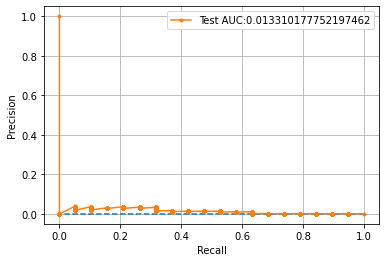

AUC for the model is: 0.013310177752197462


In [28]:
#plot the PR-AUC curve
y_scores = model.predict_proba(seq_array_test)
#y_scores = y_scores[:, 1]
prec, recall, thresholds = precision_recall_curve(label_array_test, y_scores)
pr_auc = auc(recall, prec)
plt.plot([1,0],[0,0], linestyle='--')
plt.plot(recall, prec, marker='.', label='Test AUC:' + str(pr_auc) )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()
print('AUC for the model is:',pr_auc)

## Observation:
- With only very light hyperparameter tuning for LSTM, the result is not very impressive.

 # 6. Summary

### Based on the limited tests and analysis on this case study, we have following observations:
- Based on the limited tests and analysis on this case study, we have following observations:
- The best model from this case study is the Random Forest with the baseline features after data preprocessing, with F1 = 0.2353, PR-AUC = 0.1251. (Best ROC-AUC > 0.91)
- The model with best result suggests the metric2, 4, 7 are essential to predict the failure, we also observed these three -metrics surge before devices fail.
- The model usually gets very high F1 score on the training/CV set, but poor F1 score on the test set. (overfitting)
- The addition of time sequence-related features helps the training set and CV set, but not the test set. (overfitting)
- The hyperparameter tuning improves the performance on the training set and CV set, but not on the test set.(overfitting)



# 7. Further analysis

### There are more tests or ideas for future exploration:
- The current model seems to suffer overfitting issue, further tests includes testing different splitting ratio like 50:50, simpler model, etc.
- With the current data, we could conduct more thorough investigation in each section, like exploring more algorithms, delving deeper into the LSTM hyperparameters tuning(very time-consuming).
- If we could have more data, especially the failed cases, we might be able to make better prediction. 
- If we could have domain knowledge to help understand the metrics better, we could build customer objective function to further optimize the training.
- If we could have more information of the business objective, we could adjust the threshold for classification to prioritize precision or recall or to get an optimized F1(as the red dash line pointed).
